# **Climate Prediction - Asia**

# Overview of Topic

### **Introduction**

There was a time when the climate across many Asian regions was moderate enough that simple fans were sufficient for daily comfort.
However, with the steady rise in global temperatures, air conditioners have become an essential part of every household; a visible reflection of how profoundly climate patterns are shifting.
According to multiple international climate reports, the past decade has recorded some of the warmest years on record, emphasizing the urgent need to understand and quantify regional temperature dynamics.

This project addresses that challenge by leveraging data driven machine learning techniques to analyze weather trends and predict near surface temperature variations across Asian cities.
By integrating meteorological, air quality, and astronomical factors, the study aims to uncover the underlying relationships driving temperature change and provide insights that can contribute to climate aware decision making and energy management.

### **Dataset Overview**

This study utilizes the World Weather Repository (Daily Updating) dataset from Kaggle, which provides daily meteorological observations for capital cities worldwide beginning August 29, 2023.
From the global dataset, records were filtered for Asian cities using the timezone attribute, reducing the data from 94,511 entries to 23,221 entries.
Each record includes 41 features encompassing meteorological, air quality, and astronomical variables that describe real time atmospheric conditions.
This dataset serves as a robust foundation for analyzing climatic patterns and exploring how diverse environmental factors collectively influence temperature variations across the Asian region.

Dataset Source: [World Weather Repository (Daily Updating)](https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository)


---

### **Goal**

The primary objective of this project is to develop and comparatively evaluate three machine learning regression models Ridge Regression, Random Forest, and Gradient Boosting to determine which model most effectively captures nonlinear climatic relationships while maintaining interpretability and generalization.

---

# 2. Data Collection

In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Feature Selection & Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# Warning
import warnings

I aggregated all the import here for better readability and ease of use to understand what all libraries went behind the analysis and avoid redundancy.

Total number of samples: 23221

Target variable: 'temperature_celsius'

Target variable description:
count    23221.000000
mean        25.901348
std         10.075274
min        -24.900000
25%         21.300000
50%         28.000000
75%         32.200000
max         49.200000
Name: temperature_celsius, dtype: float64 

Feature type counts:
float64    23
object     11
int64       7
Name: count, dtype: int64 


Detailed Feature Classification:
                         Feature    Dtype  Unique Values  \
0                        country   object             51   
1                  location_name   object             61   
2                       latitude  float64             93   
3                      longitude  float64             94   
4                       timezone   object             46   
5             last_updated_epoch    int64            891   
6                   last_updated   object           7337   
7            temperature_celsius  float64            642   
8         temp

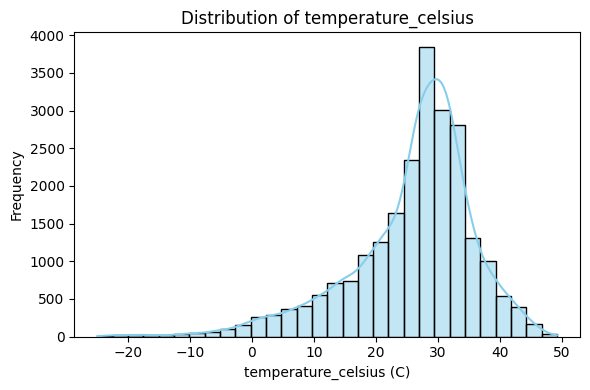

In [ ]:
# Loading the dataset
df = pd.read_csv("GlobalWeatherRepository.csv")
# Filtering Asian Data
df = df[df['timezone'].str.contains('Asia/', case=False, na=False)]

# Total number of samples
total_samples = df.shape[0]

# Descriptive statistics for the target variable 'temperature_celsius'.
target_col = 'temperature_celsius'
target_description = df[target_col].describe()

# Feature types
feature_types = df.dtypes.value_counts()

# Detailed list of types by column
detailed_types = df.dtypes

# Function to classify feature types
def classify_feature(col, dtype, unique_vals, n_samples):
    if dtype == 'object':
        return "Categorical"
    elif dtype in ['int64', 'float64']:
        # Discrete if number of unique values is small relative to total samples
        if unique_vals < 5:
            return "Discrete"
        else:
            return "Continuous"
    else:
        return "Other"

# Build a summary dataframe
feature_summary = []
for col in df.columns:
    dtype = df[col].dtype
    unique_vals = df[col].nunique()
    feature_type = classify_feature(col, dtype, unique_vals, df.shape[0])
    feature_summary.append([col, dtype, unique_vals, feature_type])

feature_summary_df = pd.DataFrame(feature_summary, columns=["Feature", "Dtype", "Unique Values", "Categorical/Discrete/Continuous"])

# Output all results
print(f"Total number of samples: {total_samples}\n")
print(f"Target variable: '{target_col}'\n")
print("Target variable description:")
print(target_description, "\n")
print("Feature type counts:")
print(feature_types, "\n")
print("\nDetailed Feature Classification:")
print(feature_summary_df)
print("\nPreview of dataset:")
print(df.head())
print("\nNumerical Summary:")
print(df.describe())

# Regression target visualization
plt.figure(figsize=(6,4))
sns.histplot(df[target_col], bins=30, kde=True, color='skyblue')
plt.title(f'Distribution of {target_col}')
plt.xlabel(f'{target_col} (C)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The dataset was first examined to verify structure, data types, and label distribution.
A total of 23,221 samples and 41 features were identified after filtering for Asian cities.
The target variable temperature_celsius was analyzed to confirm suitability for regression modeling.

Key Observations

- Continuous features (example pressure, humidity, wind speed, pollutant indices) -> 30
- Categorical features (example country, timezone, condition_text) -> 10
- Ordinal / integer coded features (eexample UV index, EPA index) -> 4
(Ordinal variables are part of the 41 total features, not additional.)
- **Target Distribution**: Mean ~ 25.9 Celsius, SD ~ 10 Celsius, range −25 Celsius to 49 Celsius.
- Slight right skewness, with most observations between 20 Celsius and 35 Celsius. temperature_celsius was chosen as target as it is the most known temperature feature and reliable for machine learning model training.
- It was also observed that some features that shouldn't have negative values have them as the lowest values which will have to be handled in the futher steps.

# 3. Data Pre-Preproccesing

In [ ]:
df_cleaned = df
# Identify duplicates
duplicates_count = df_cleaned.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")

Number of duplicate rows: 0


here, I am checking if there are any Duplicate values.

In [ ]:
# Handle duplicates by dropping them
df_cleaned = df_cleaned.drop_duplicates()
print(f"Shape after removing duplicates: {df_cleaned.shape}")
print(f"Remaining duplicates: {df_cleaned.duplicated().sum()}")

Shape after removing duplicates: (23221, 41)
Remaining duplicates: 0


here, I am dropping Duplicate values to make sure there is no bias in the initial stages of data.

In [ ]:
# Identify missing values
missing_values = df_cleaned.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone   

It was found that there are no missing values in the dataset which is a good sign and shows that we have good amount of real data to deal with, though there may be other factors affecting it but missing values is not one of them.

In [ ]:
# Columns that must not be negative based on physical meaning
non_negative_cols = [
    'wind_mph', 'wind_kph', 'gust_mph', 'gust_kph',
    'pressure_mb', 'pressure_in',
    'precip_mm', 'precip_in',
    'humidity', 'cloud', 'visibility_km', 'visibility_miles',
    'uv_index', 'wind_degree',
    'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
    'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
    'air_quality_PM2.5', 'air_quality_PM10',
    'air_quality_us-epa-index', 'air_quality_gb-defra-index',
    'moon_illumination'
]

# Replace invalid negatives only in numeric columns that actually exist
for col in non_negative_cols:
    if col in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned[col]):
        neg_count = (df_cleaned[col] < 0).sum()
        if neg_count > 0:
            print(f"{col}: {neg_count} negative value/s replaced with NaN.")
            df_cleaned.loc[df_cleaned[col] < 0, col] = np.nan


# Impute numeric features with median, categorical with mode
for col in df_cleaned.columns:
    if df_cleaned[col].dtype in ['float64', 'int64']:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
    else:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

print("\nMissing values after imputation:")
print(df_cleaned.isnull().sum().sum(), "remaining")

air_quality_PM10: 1 negative value/s replaced with NaN.

Missing values after imputation:
0 remaining


Initially we discussed that there are no missing values but as observed in the beginiing of data description and initial analysis, in this step we are handling negative values in non negative features with the use of imputation, both, median and mode imputation based on data type of numerical and textual respectively.

As observed in the result we do have negative values that we first replace with Nan and then imputed accordingly.

This makes sure that our data has no unwanted negatives in non negative features and that the data we have is reliable.

In [ ]:
# Identifying outliers using IQR method
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
    return outliers, lower_bound, upper_bound

# Identifying continuous features (excluding categorical/ordinal ones with few unique values <=5)
continuous_features = [
    col for col in df_cleaned.select_dtypes(include=[np.number]).columns
    if df_cleaned[col].nunique() > 5
]

print("Continuous features considered for outlier detection:", continuous_features)

print("\nOutliers before removal (only continuous features):")
for col in continuous_features:
    outliers, lb, ub = detect_outliers_iqr(df_cleaned, col)
    if outliers > 0:
        print(f"{col}: {outliers} outliers (bounds: {lb:.2f}, {ub:.2f})")

Continuous features considered for outlier detection: ['latitude', 'longitude', 'last_updated_epoch', 'temperature_celsius', 'temperature_fahrenheit', 'wind_mph', 'wind_kph', 'wind_degree', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 'visibility_miles', 'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'moon_illumination']

Outliers before removal (only continuous features):
temperature_celsius: 1053 outliers (bounds: 4.95, 48.55)
temperature_fahrenheit: 1047 outliers (bounds: 40.75, 119.55)
wind_mph: 532 outliers (bounds: -5.30, 20.30)
wind_kph: 504 outliers (bounds: -8.95, 33.05)
pressure_mb: 459 outliers (bounds: 992.50, 1028.50)
pressure_in: 581 outliers (bounds: 29.32, 30.36)
precip_mm: 47

In this step we are looking for outliers in the numerical data using IQR method, IQR was chosen over Z score because it is non parametruc, scale independent, and more robust for skewed data as observed in the initial data analysis where `temperature_celsius` distribution was observed to be right skewed.

It was found that most number of outliers in features like `visibility_km` with 4949, `visibility_miles` with 4941, `precip_mm` with 4745, `precip_in` with 4131, `air_quality_Carbon_Monoxide` with 2426 and `air_quality_PM10` with 2164 outliers.

The number of outliers in the data show that it is necessary to handle these outlier via capping rather than dropping them. This way we will preserve data size while limiting the influence of extreme values.

In [ ]:
for col in continuous_features:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_cleaned[col] = np.where(df_cleaned[col] < lower_bound, lower_bound,
                        np.where(df_cleaned[col] > upper_bound, upper_bound, df_cleaned[col]))

print("\nOutlier capping applied to continuous features only.")


# valid_negative_cols = [
#     'latitude', 'longitude', 'last_updated_epoch',
#     'temperature_celsius', 'temperature_fahrenheit',
#     'feels_like_celsius', 'feels_like_fahrenheit'
# ]

# # Applying IQR capping only to appropriate continuous (non negative physical) features
# for col in continuous_features:
#     if col not in valid_negative_cols:
#         Q1 = df_cleaned[col].quantile(0.25)
#         Q3 = df_cleaned[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR

#         df_cleaned[col] = np.where(
#             df_cleaned[col] < lower_bound, lower_bound,
#             np.where(df_cleaned[col] > upper_bound, upper_bound, df_cleaned[col])
#         )

# Re checking outliers after capping
print("\nOutliers after capping:")
for col in continuous_features:
    outliers, lb, ub = detect_outliers_iqr(df_cleaned, col)
    print(f"{col}: {outliers} outliers remaining")

print(f"\nShape after removing duplicates: {df_cleaned.shape}")


Outlier capping applied to continuous features only.

Outliers after capping:
latitude: 0 outliers remaining
longitude: 0 outliers remaining
last_updated_epoch: 0 outliers remaining
temperature_celsius: 0 outliers remaining
temperature_fahrenheit: 0 outliers remaining
wind_mph: 0 outliers remaining
wind_kph: 0 outliers remaining
wind_degree: 0 outliers remaining
pressure_mb: 0 outliers remaining
pressure_in: 0 outliers remaining
precip_mm: 0 outliers remaining
precip_in: 0 outliers remaining
humidity: 0 outliers remaining
cloud: 0 outliers remaining
feels_like_celsius: 0 outliers remaining
feels_like_fahrenheit: 0 outliers remaining
visibility_km: 0 outliers remaining
visibility_miles: 0 outliers remaining
uv_index: 0 outliers remaining
gust_mph: 0 outliers remaining
gust_kph: 0 outliers remaining
air_quality_Carbon_Monoxide: 0 outliers remaining
air_quality_Ozone: 0 outliers remaining
air_quality_Nitrogen_dioxide: 0 outliers remaining
air_quality_Sulphur_dioxide: 0 outliers remaining

### **Practical Challenge: Handling Negative Temperatures**

During outlier handling, a key decision point arose concerning how to treat negative values in the `temperature_celsius` column.
Two approaches were tested:

1. Selective Capping (Choice 1): Excluding temperature columns from the IQR rule to preserve naturally occurring sub zero readings in colder regions.

2. Uniform Capping (Choice 2): Applying the same IQR based rule to all continuous variables for a standardized, future proof workflow.

While the first option maintained meteorological realism, it introduced data specific exceptions that would require manual adjustments for every dataset variant.
Therefore, the second approach keeping the standard IQR rule consistent across all features; was ultimately retained to ensure code reusability and methodological consistency.

Although this slightly increased RMSE values (notably for the Random Forest model), it guaranteed a scalable, automated preprocessing pipeline adaptable to future climate datasets.
Importantly, the dataset shape remained unchanged (23,221 × 41), confirming that no samples were lost after capping.

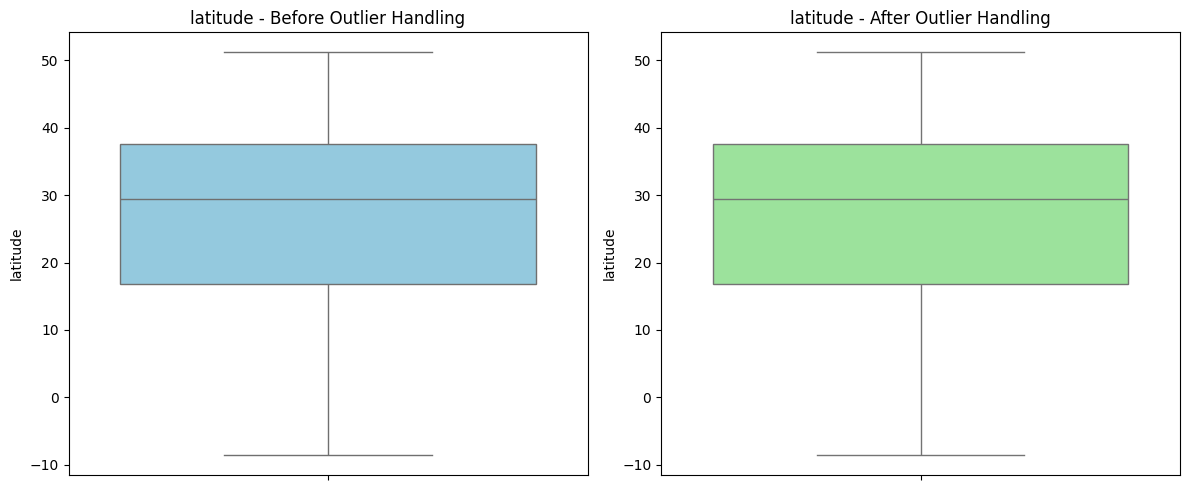

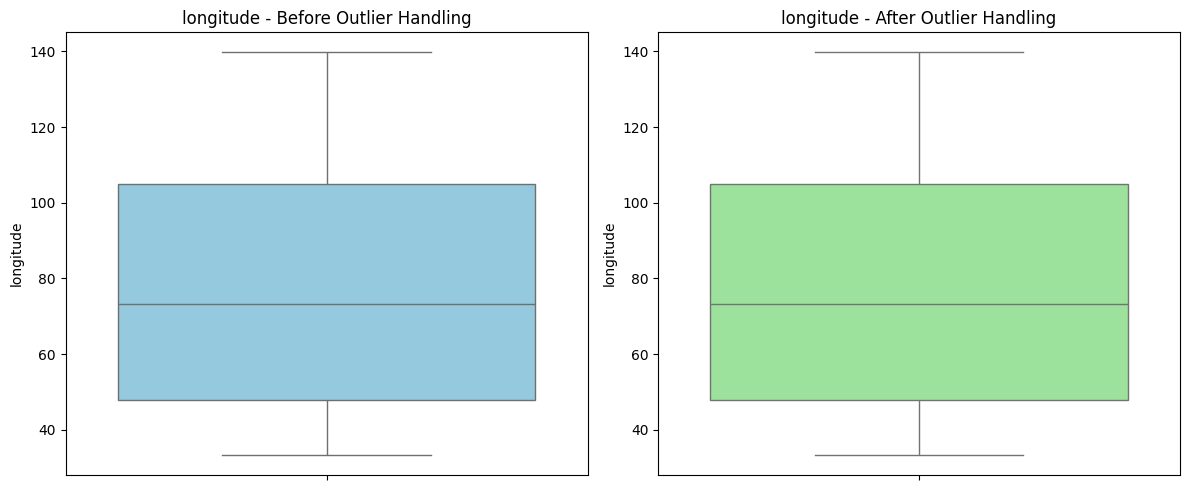

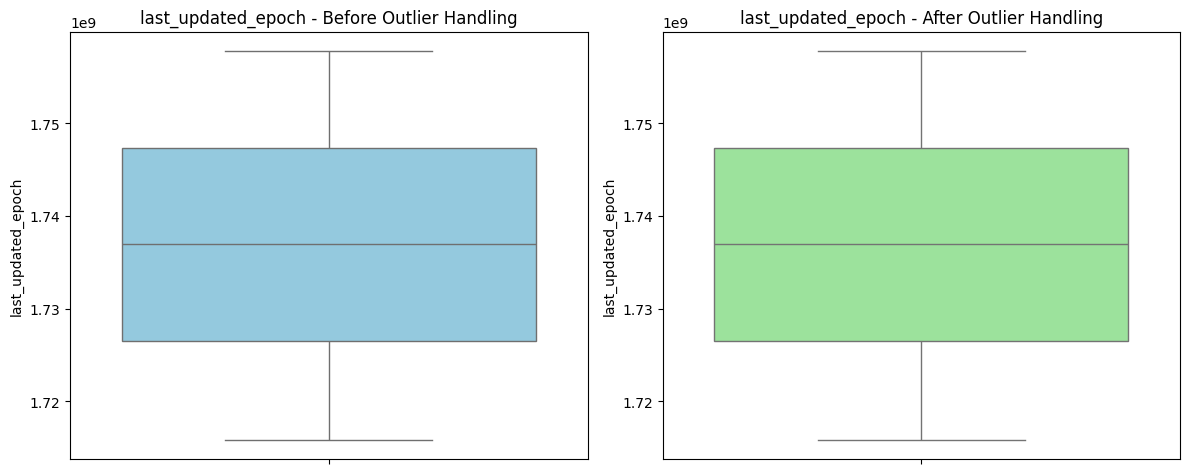

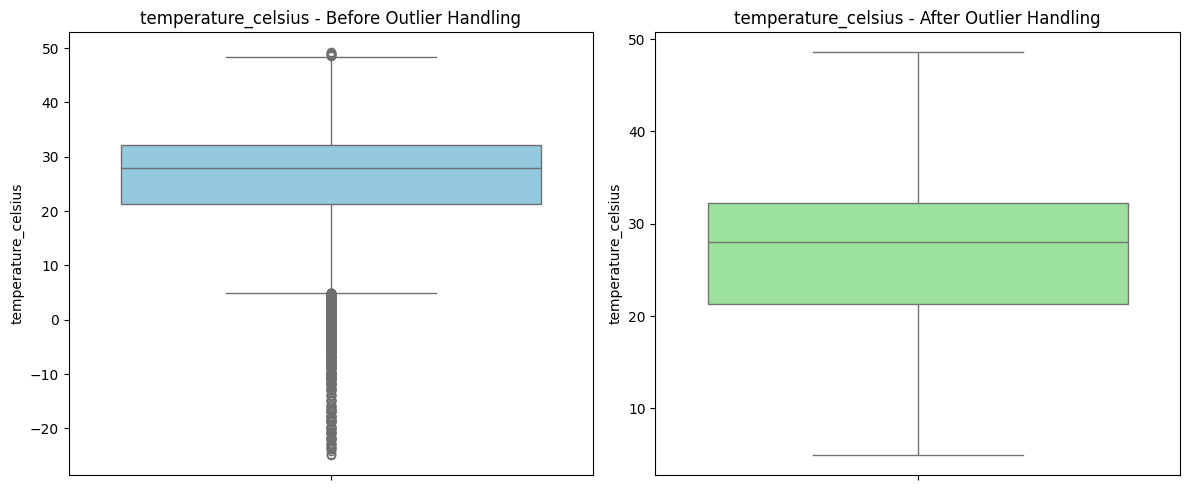

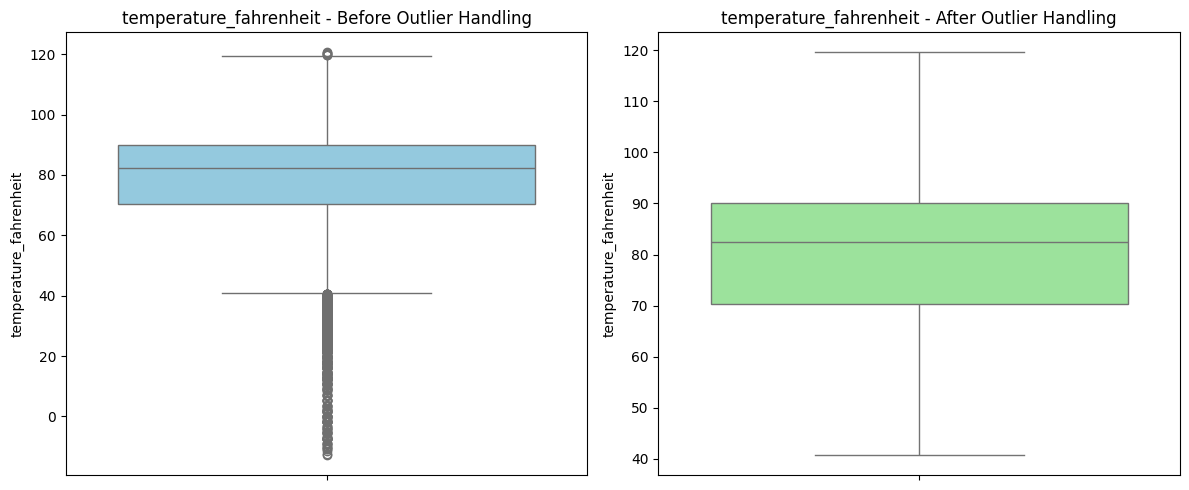

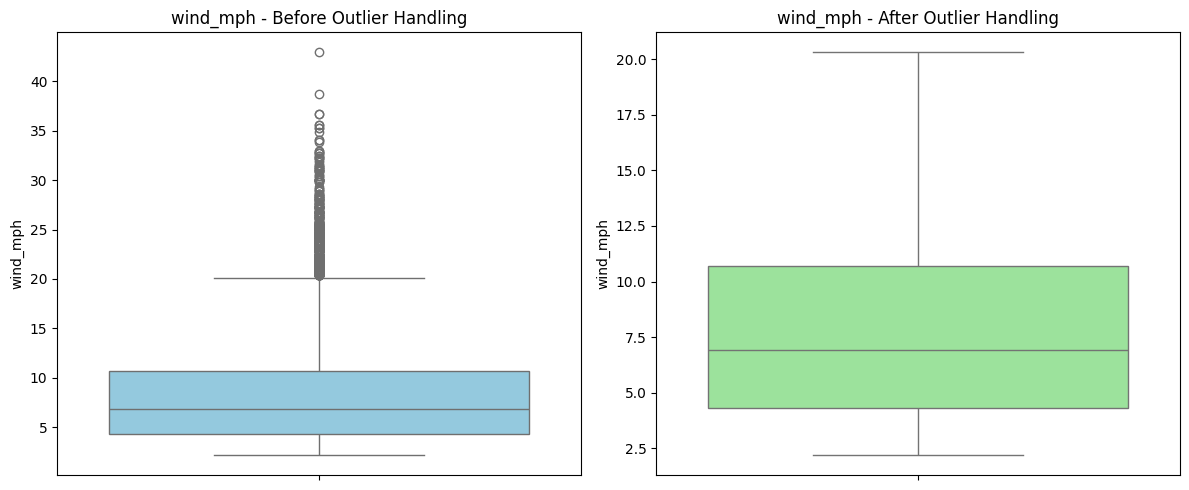

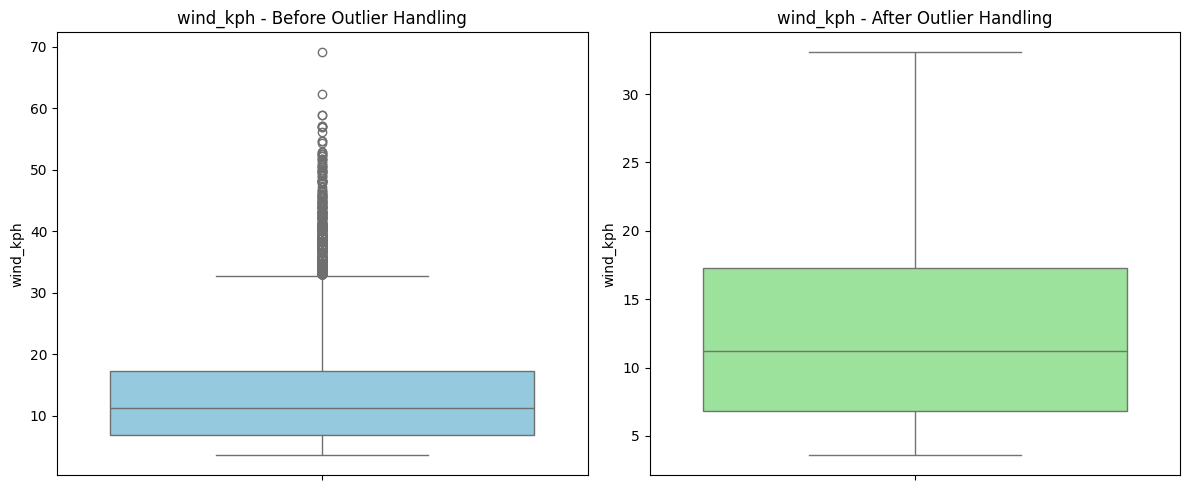

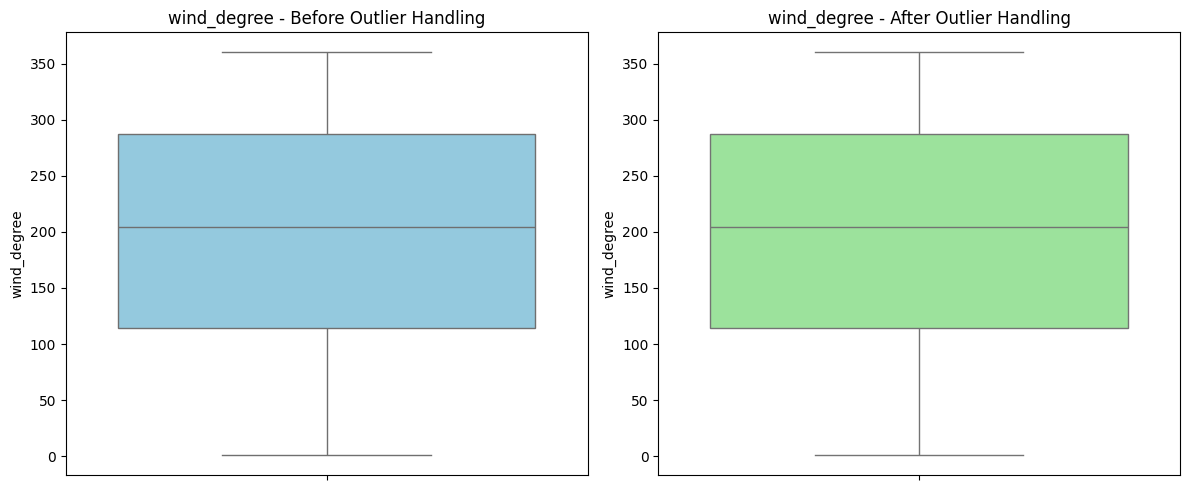

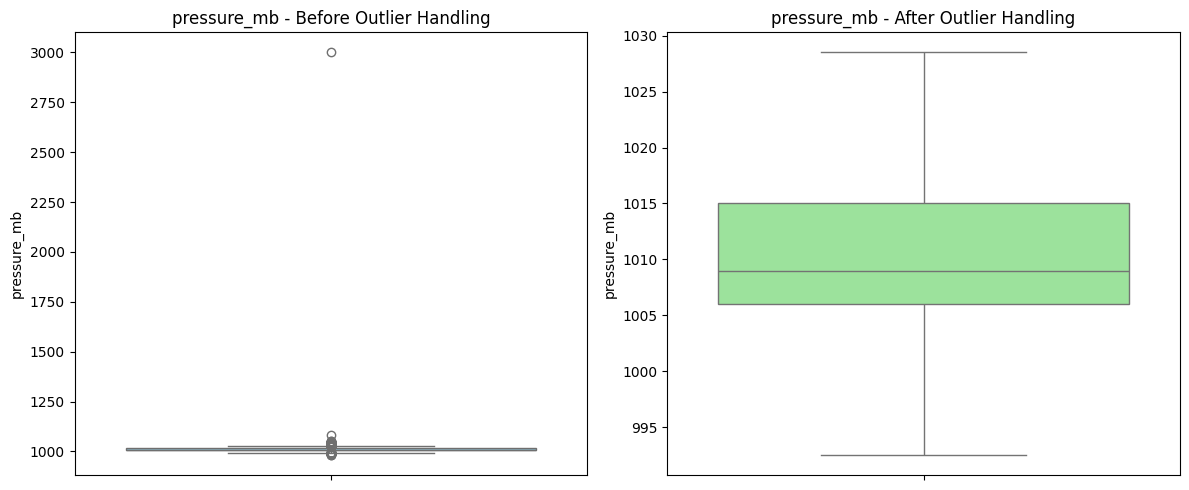

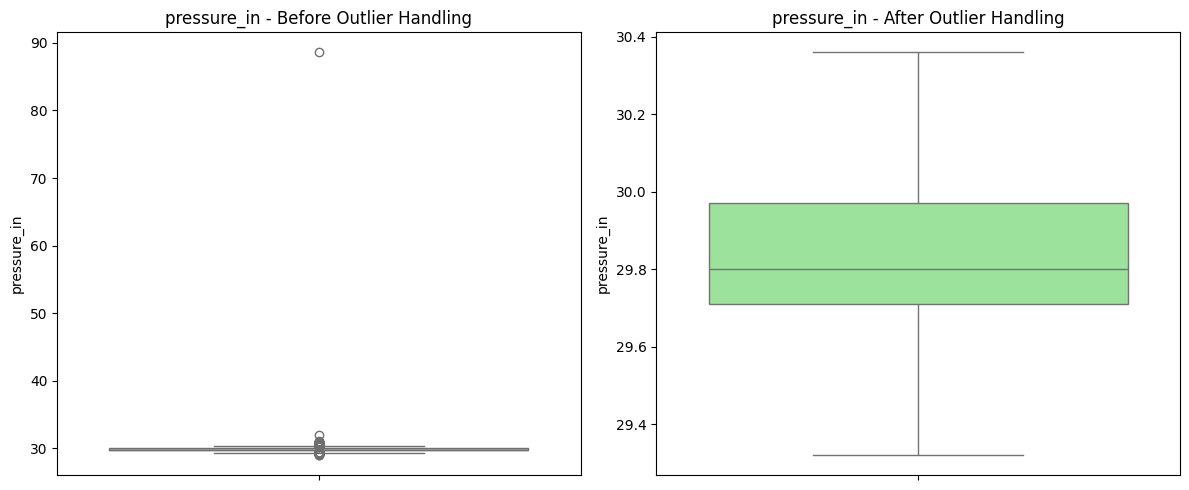

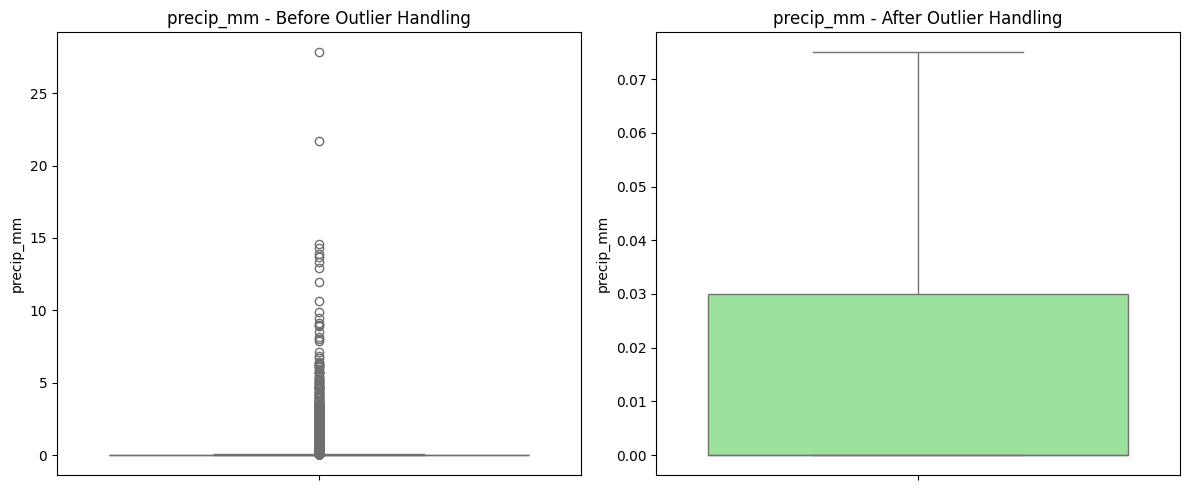

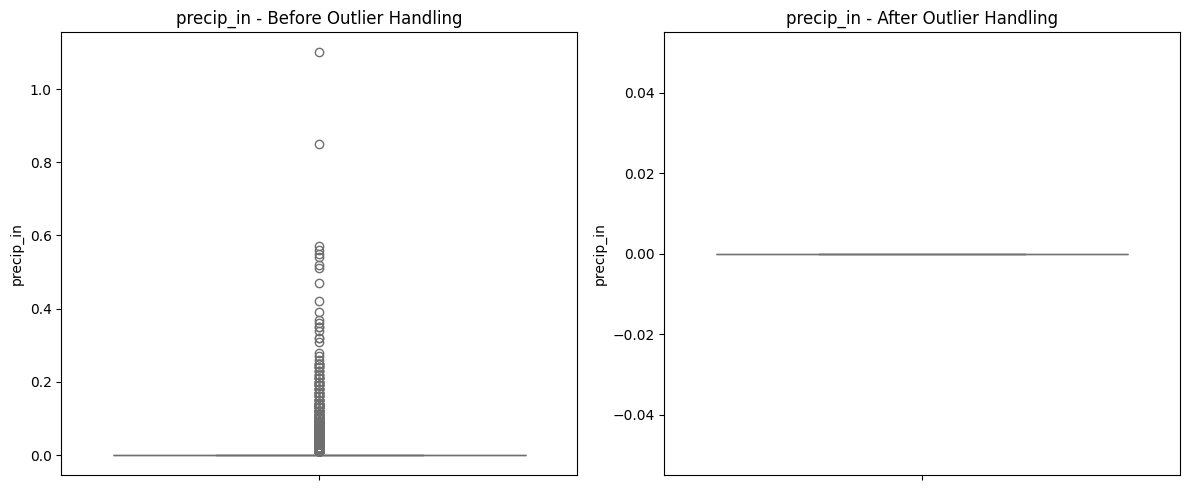

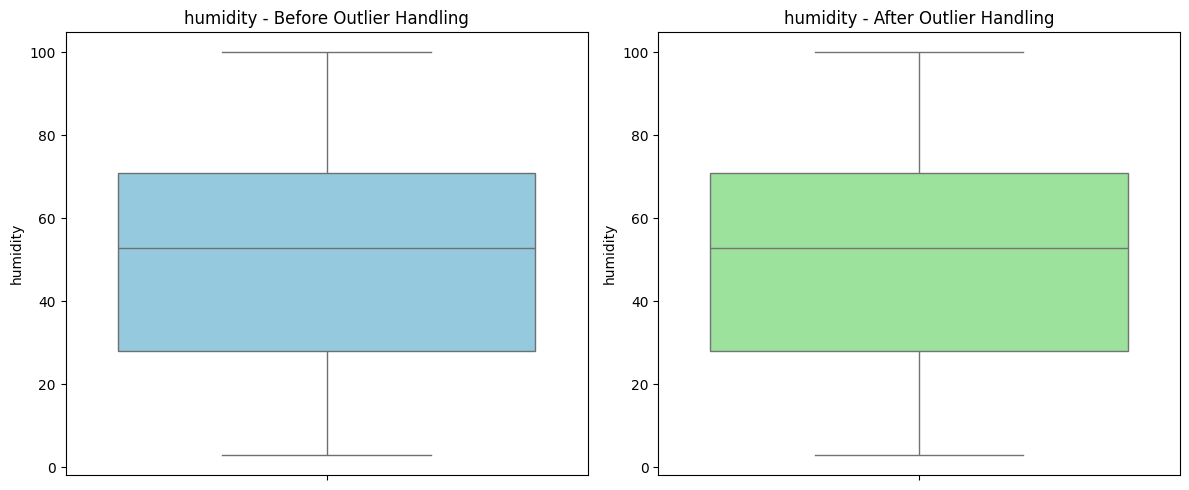

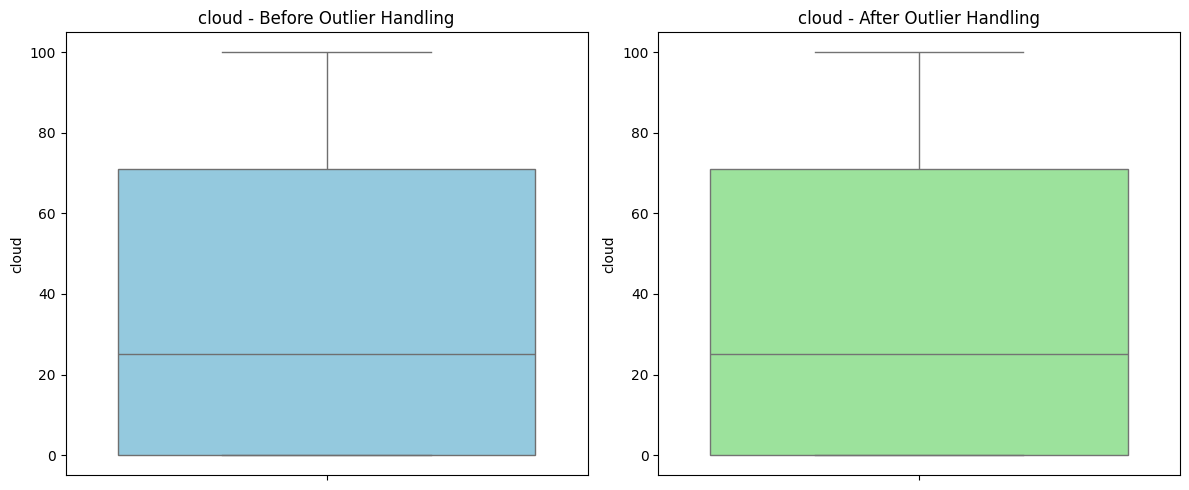

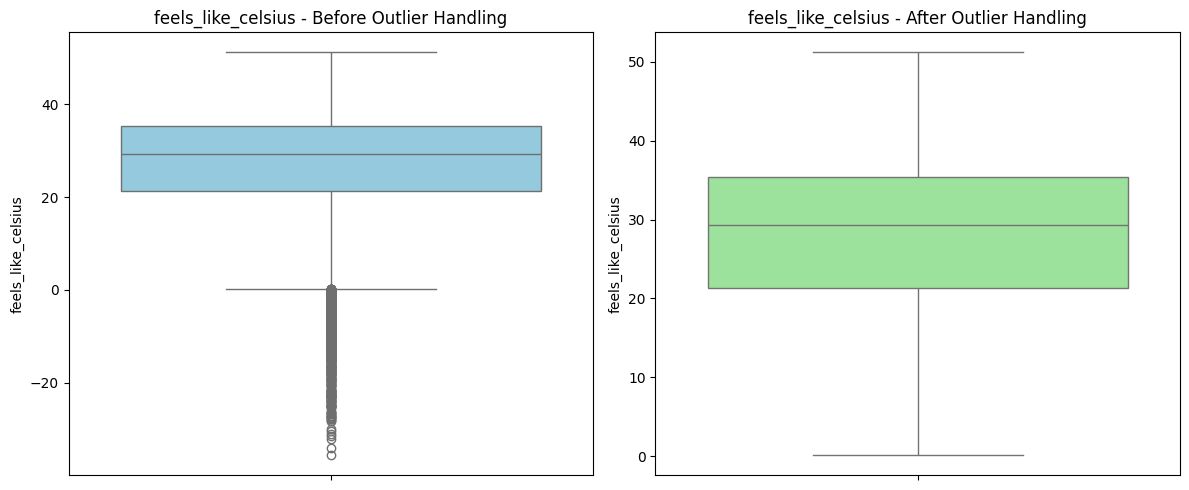

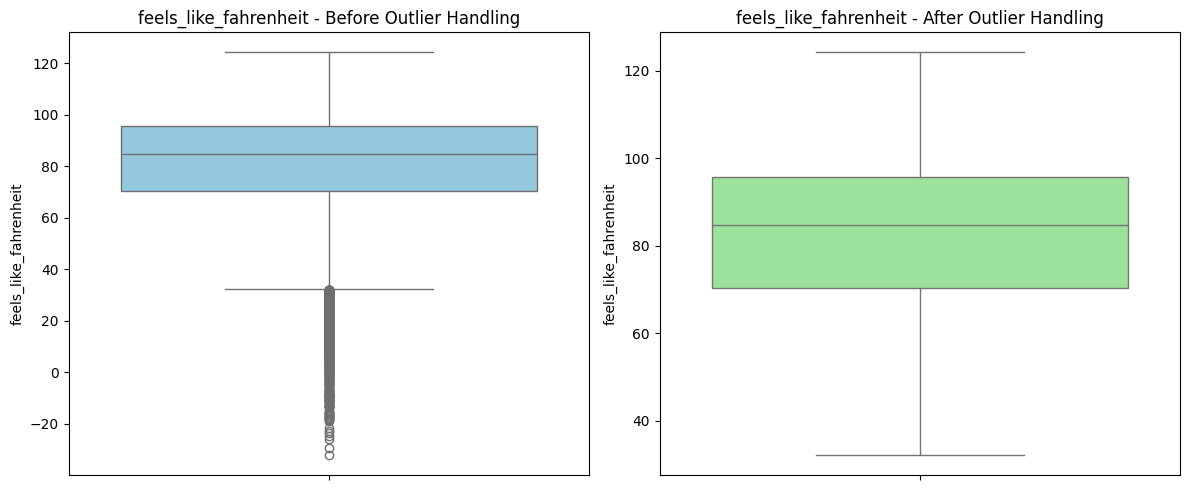

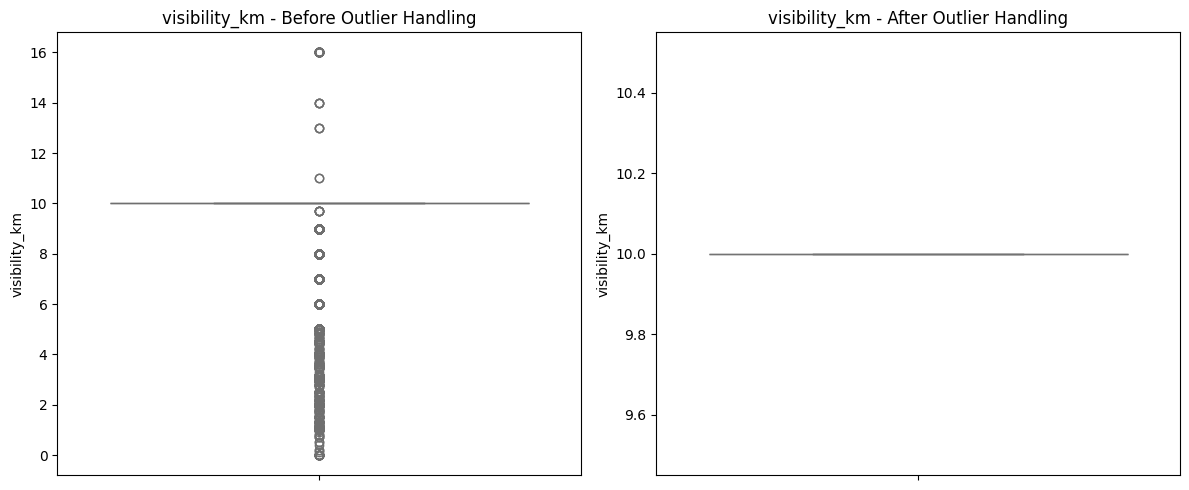

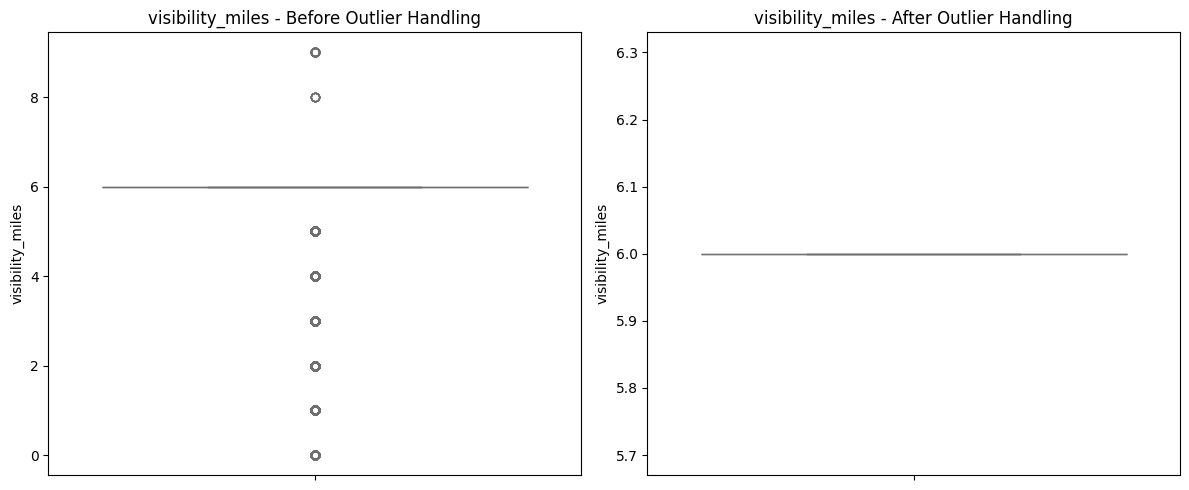

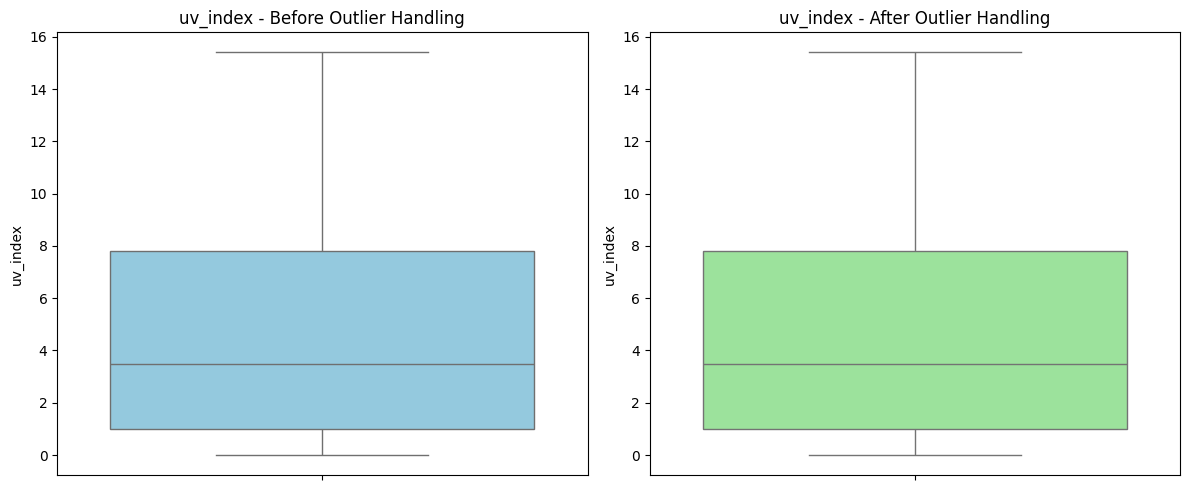

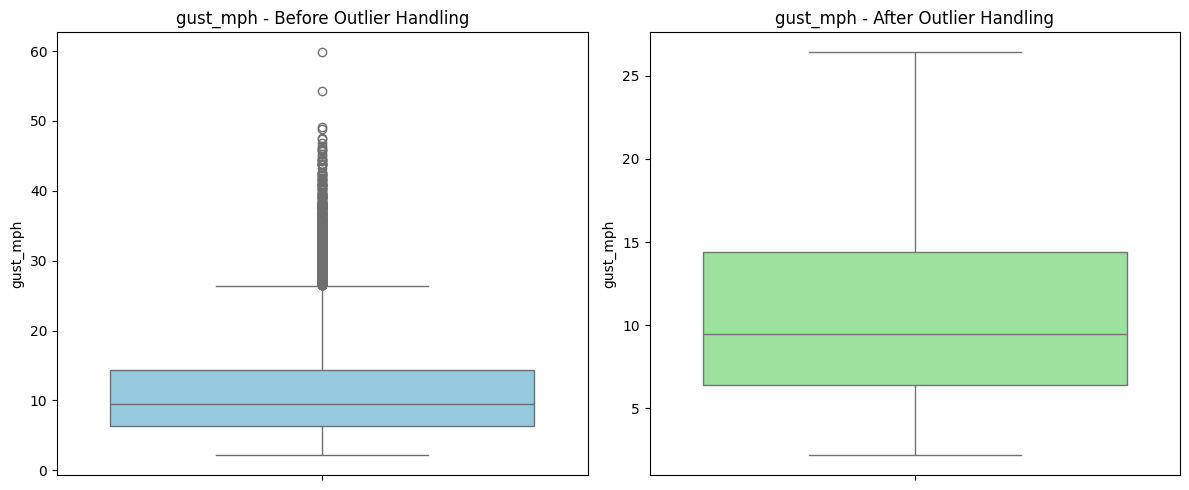

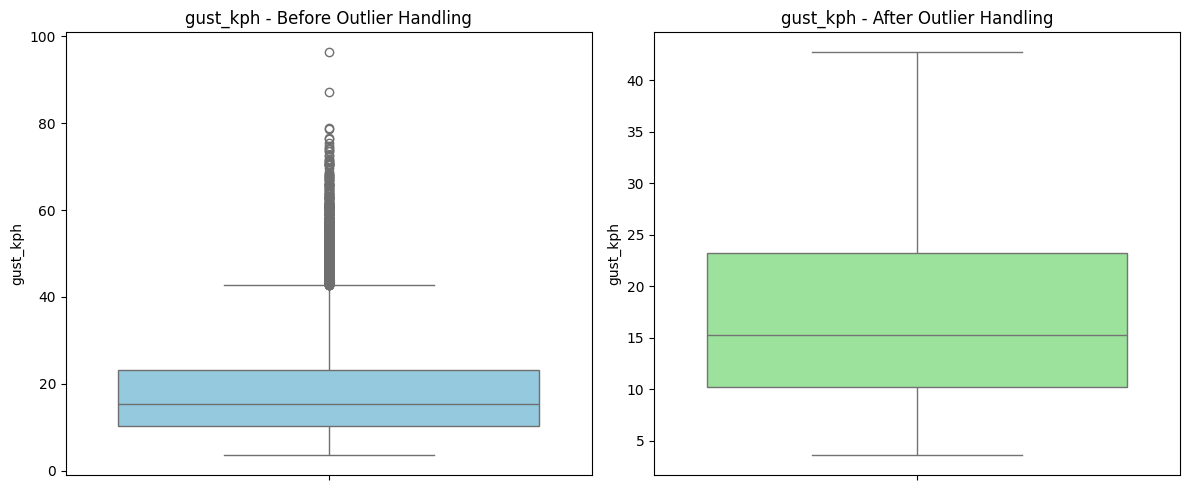

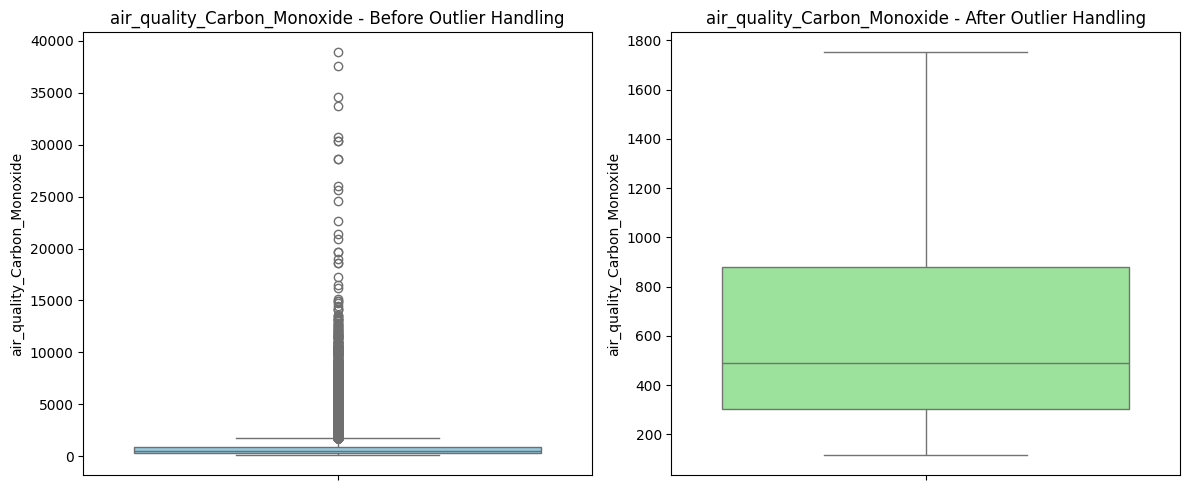

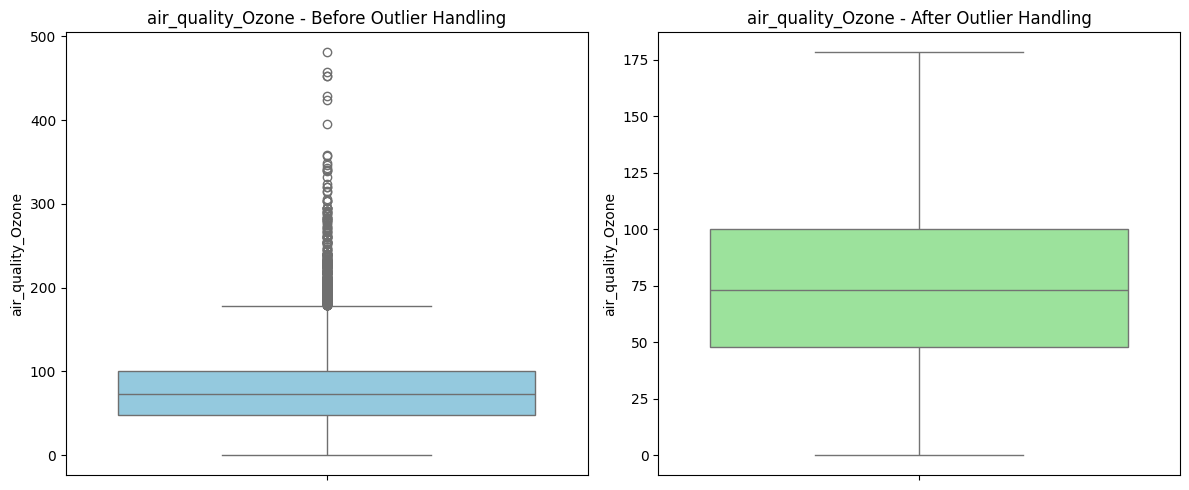

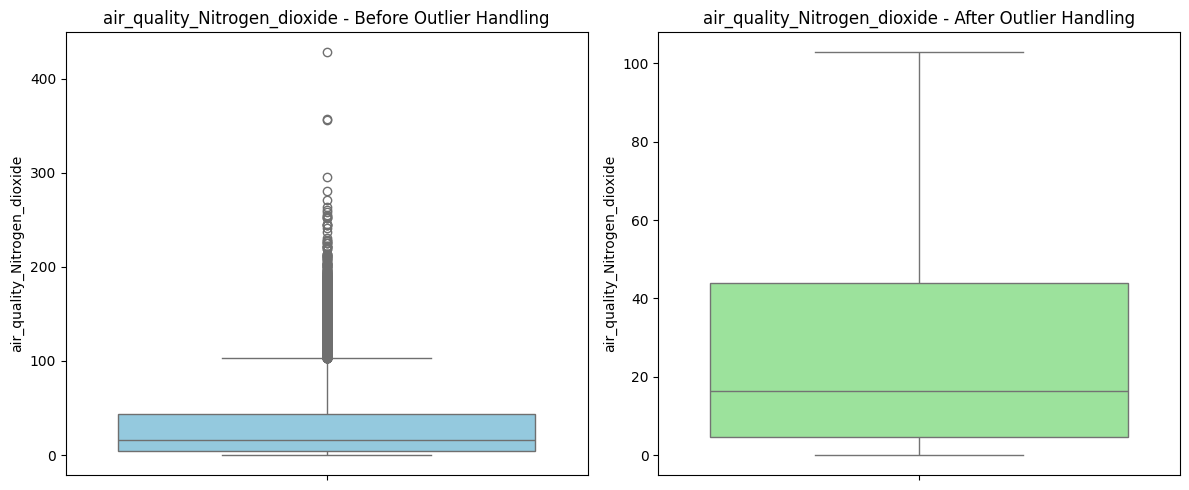

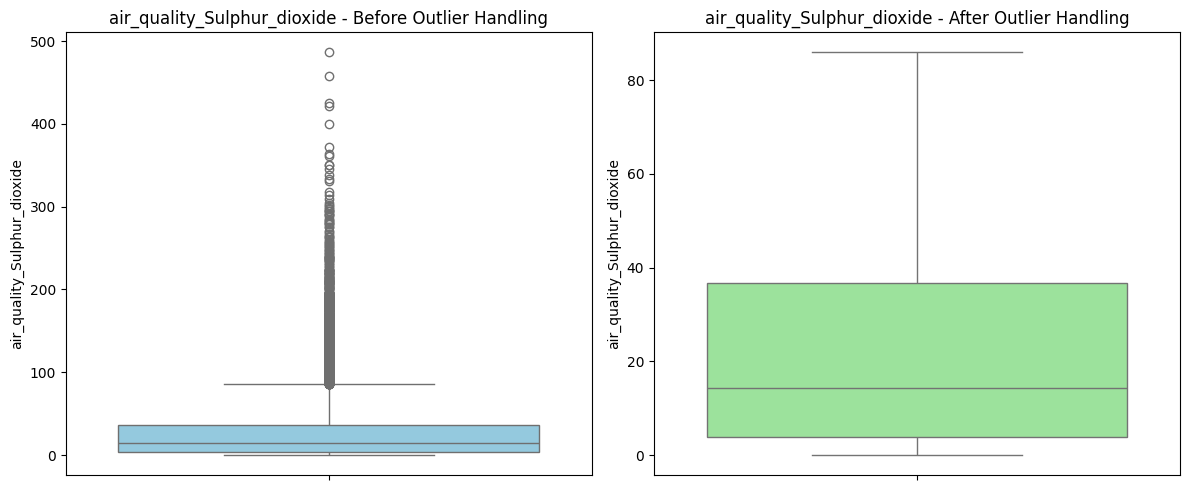

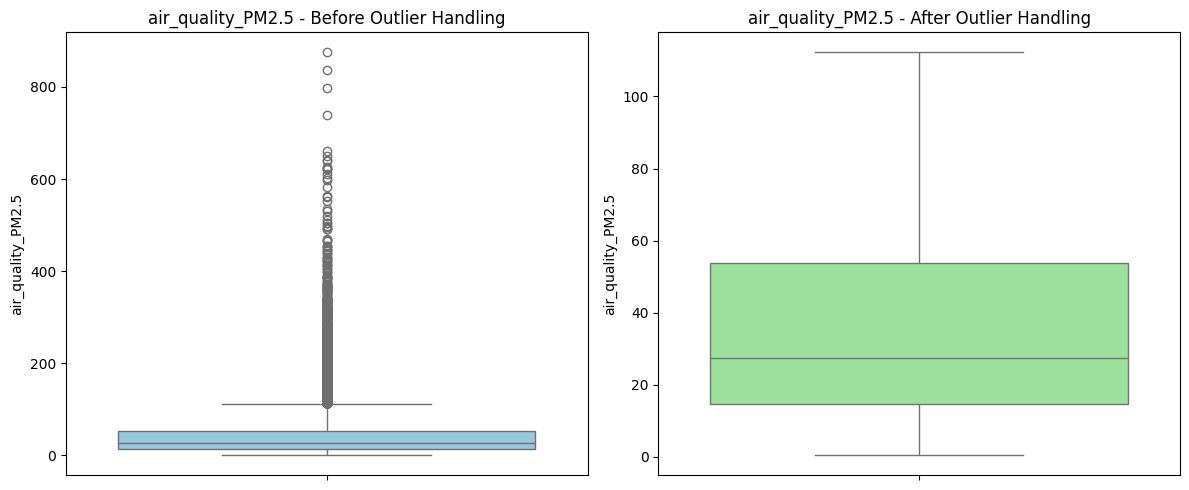

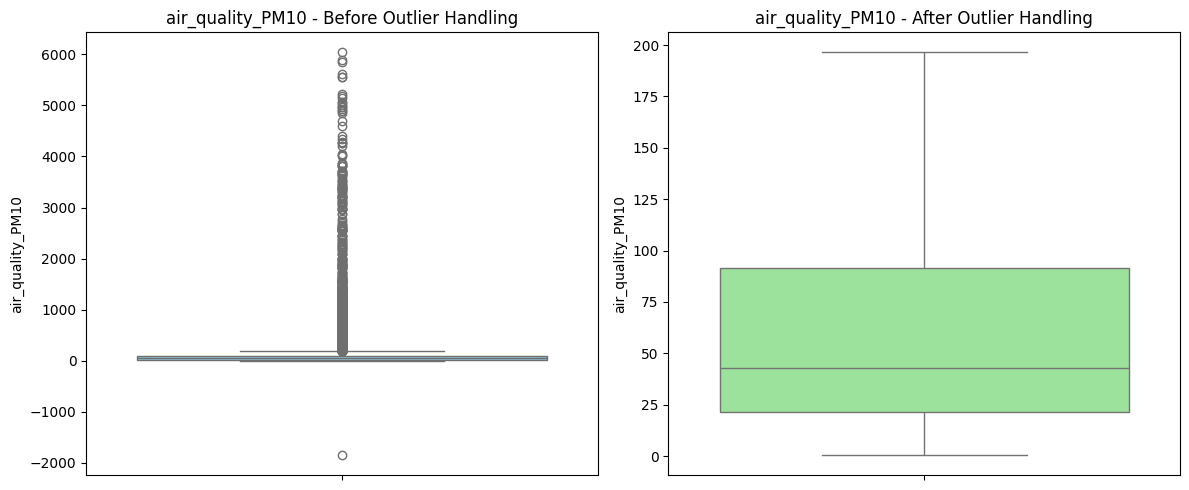

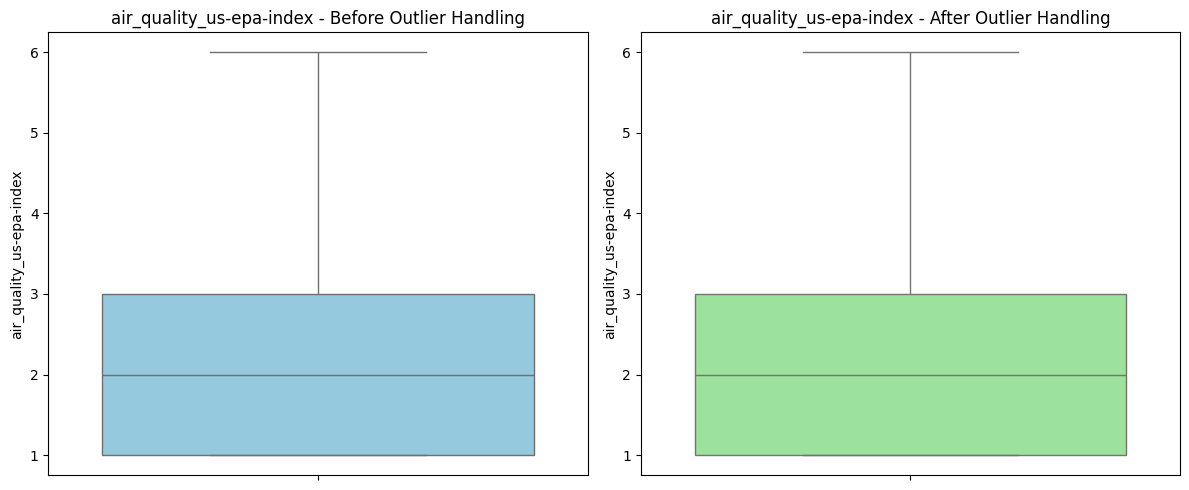

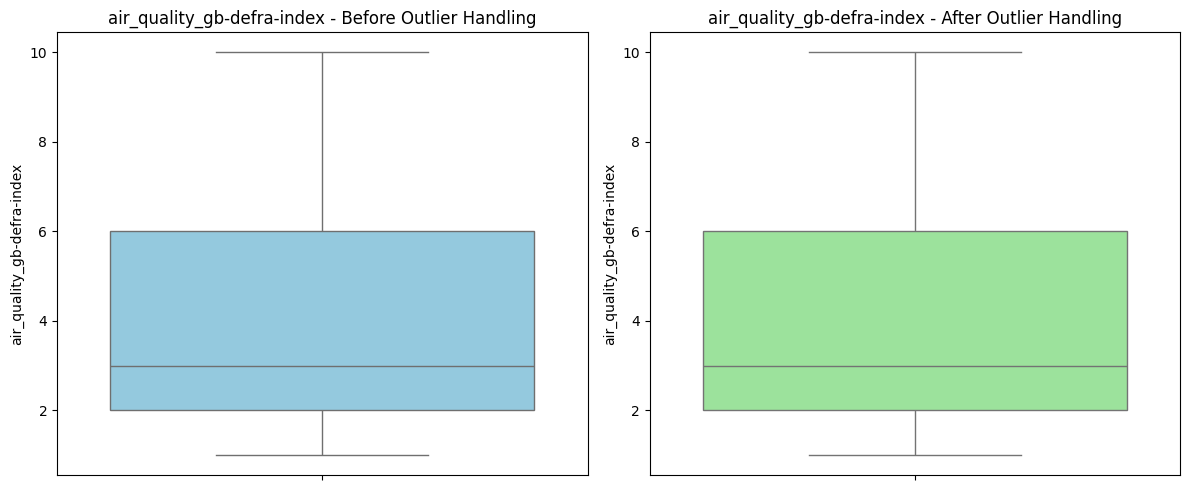

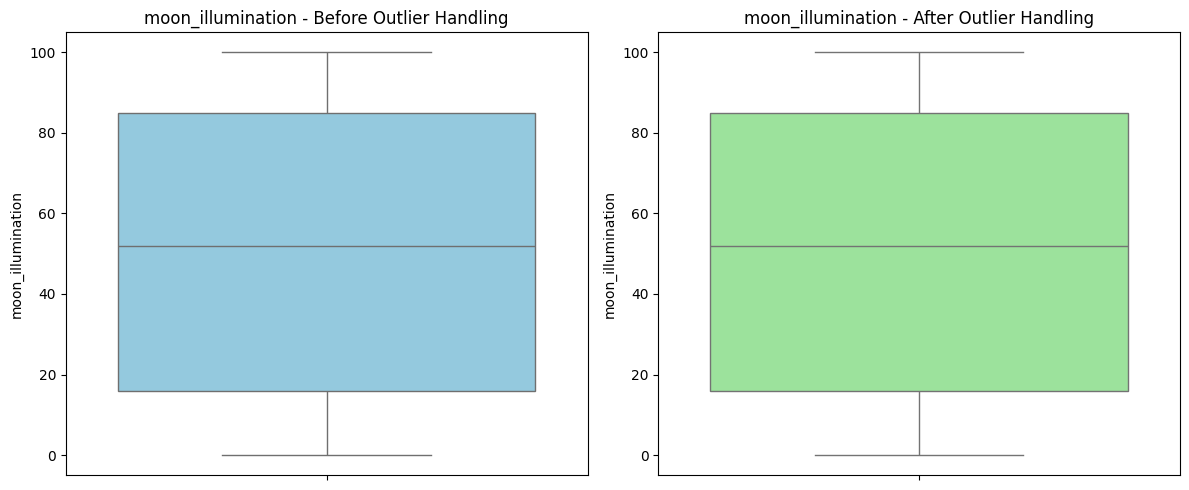

In [ ]:
for col in continuous_features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Before capping
    sns.boxplot(y=df[col], ax=axes[0], color="skyblue")
    axes[0].set_title(f"{col} - Before Outlier Handling")

    # After capping
    sns.boxplot(y=df_cleaned[col], ax=axes[1], color="lightgreen")
    axes[1].set_title(f"{col} - After Outlier Handling")

    plt.tight_layout()
    plt.show()

### **Observations**

- The pre processing plots show several features; such as precip_mm, PM10, and gust_kph; with elongated whiskers and extreme points, confirming the presence of high magnitude outliers.

- After IQR based capping, whiskers became shorter and outlier markers disappeared, demonstrating that extreme values were effectively capped within the interquartile boundaries.

- The median and interquartile range (IQR) remained largely unchanged, indicating that the central tendency and variability of the data were preserved.

- Features like moon_illumination or humidity, which already had compact distributions, remained nearly identical before and after capping; proving that the method did not distort valid data.

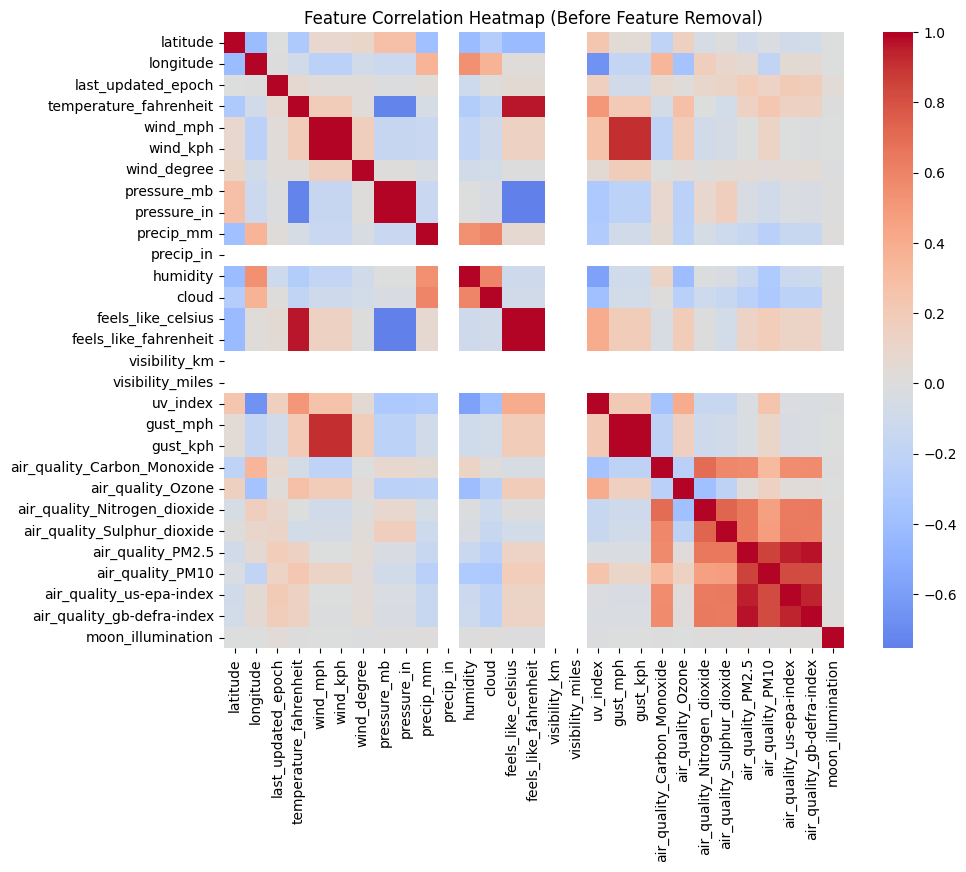

                   Feature            VIF
13      feels_like_celsius  112028.212497
14   feels_like_fahrenheit  111978.354135
18                gust_mph   25228.709753
19                gust_kph   25195.671135
5                 wind_kph   10181.573911
4                 wind_mph   10160.964251
7              pressure_mb    1173.114752
8              pressure_in    1172.756988
3   temperature_fahrenheit      27.266465
24       air_quality_PM2.5      24.472697


In [ ]:
warnings.filterwarnings("ignore", message="divide by zero encountered", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered", category=RuntimeWarning)
numeric_df = df_cleaned.select_dtypes(include=[np.number]).drop(columns=["temperature_celsius"], errors='ignore')

plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap (Before Feature Removal)")
plt.show()

vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i)
                   for i in range(numeric_df.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data.head(10))

### ***Feature Reduction using VIF Filter***

### **Filter Based, Multicolinearity Analysis**

A Pearson correlation heatmap was used to identify redundant relationships among continuous variables. Strong correlations were observed between unit duplicate features such as
- temperature_celsius & temperature_fahrenheit,
- feels_like_celsius & feels_like_fahrenheit,
- wind_mph & wind_kph, and
- pressure_mb & pressure_in.

VIF analysis confirmed severe multicollinearity, with scores exceeding 10,000 for several features (feels_like_celsius, wind_kph, gust_kph, etc.).

In [ ]:
# Dropped unit duplicates to avoid multicollinearity
drop_cols = [
    # Unit duplicates & redundant units
    "temperature_fahrenheit", "feels_like_fahrenheit",
    "wind_mph", "pressure_in", "precip_in", "visibility_miles", "gust_mph",
    # Textual / categorical not generalizable
    "condition_text", "sunrise", "sunset", "moonrise", "moonset", "moon_phase",
    # Temporal metadata
    "last_updated", "last_updated_epoch",
    # Redundant categorical features
    "location_name", "timezone", "wind_direction",
    # Weakly correlated astronomical features
    "moon_illumination"
]


use_df = df_cleaned.drop(columns=[c for c in drop_cols if c in df_cleaned.columns]).copy()

# Features/Target Split
y = use_df[target_col].values
X = use_df.drop(columns=[target_col])

# Re analysizing column types
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("Num cols:", len(num_cols), "| Cat cols:", len(cat_cols))

# Rechecking VIF Score
X_vif = X[num_cols].dropna()

# Initialize DataFrame to store VIF results
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Sort and display results
vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)
print("\nVariance Inflation Factor (VIF) after dropping redundant columns:\n")
print(vif_data)

Num cols: 20 | Cat cols: 1

Variance Inflation Factor (VIF) after dropping redundant columns:

                         Feature           VIF
0                  visibility_km  59575.333131
1              air_quality_PM2.5     24.218890
2     air_quality_gb-defra-index     17.631312
3       air_quality_us-epa-index     11.187515
4                       gust_kph      6.681560
5                       wind_kph      6.597144
6               air_quality_PM10      6.001676
7   air_quality_Nitrogen_dioxide      3.916495
8                       uv_index      3.523981
9             feels_like_celsius      3.450749
10                   pressure_mb      2.864028
11   air_quality_Carbon_Monoxide      2.705782
12                     longitude      2.688015
13   air_quality_Sulphur_dioxide      2.608795
14                      humidity      2.579348
15                      latitude      2.012193
16                         cloud      1.960235
17             air_quality_Ozone      1.901199
18          

### **Observations:**
- To improve model stability and eliminate multicollinearity, redundant and unit repeated features were dropped, reducing the dataset from 41 to 21 columns.
- Post reduction VIF scores fell below the critical threshold (mostly < 10), confirming that multicollinearity was successfully resolved.
- This step simplified model interpretation while retaining all essential meteorological and air quality predictors.

In [ ]:
numeric_pipe = Pipeline([
    ("power", PowerTransformer(method='yeo-johnson'))
])

categorical_pipe = Pipeline([
     # collapsing rare categories
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=0.01))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

### **Transforming & Encoding**

- PowerTransformer was used instead of StandardScaler to handle non Gaussian and skewed numeric distributions, as it stabilizes variance and normalizes data more effectively for tree based and linear models.

- OneHotEncoder with min_frequency=0.01 was applied to handle categorical variables, collapsing rare categories to prevent sparse matrices and overfitting from infrequent class values.

- A Pipeline was introduced to ensure a clean, leak proof preprocessing workflow, where transformations (scaling, encoding) are applied consistently during both training and testing phases.



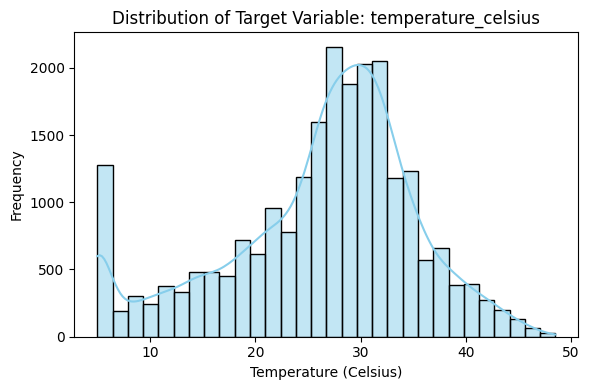

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df_cleaned['temperature_celsius'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of Target Variable: temperature_celsius")
plt.xlabel("Temperature (Celsius)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

There is significant improvement in the distribution of temperature_celsius data, showing a bell shaped curve, validating decrement in skew.

Top 10 most skewed features (before transform):
precip_mm                       1.215859
air_quality_Sulphur_dioxide     1.186954
air_quality_Nitrogen_dioxide    1.177804
air_quality_Carbon_Monoxide     1.130281
air_quality_PM10                1.125535
air_quality_PM2.5               1.083042
gust_kph                        0.862838
air_quality_gb-defra-index      0.848547
wind_kph                        0.832248
air_quality_us-epa-index        0.804232
dtype: float64


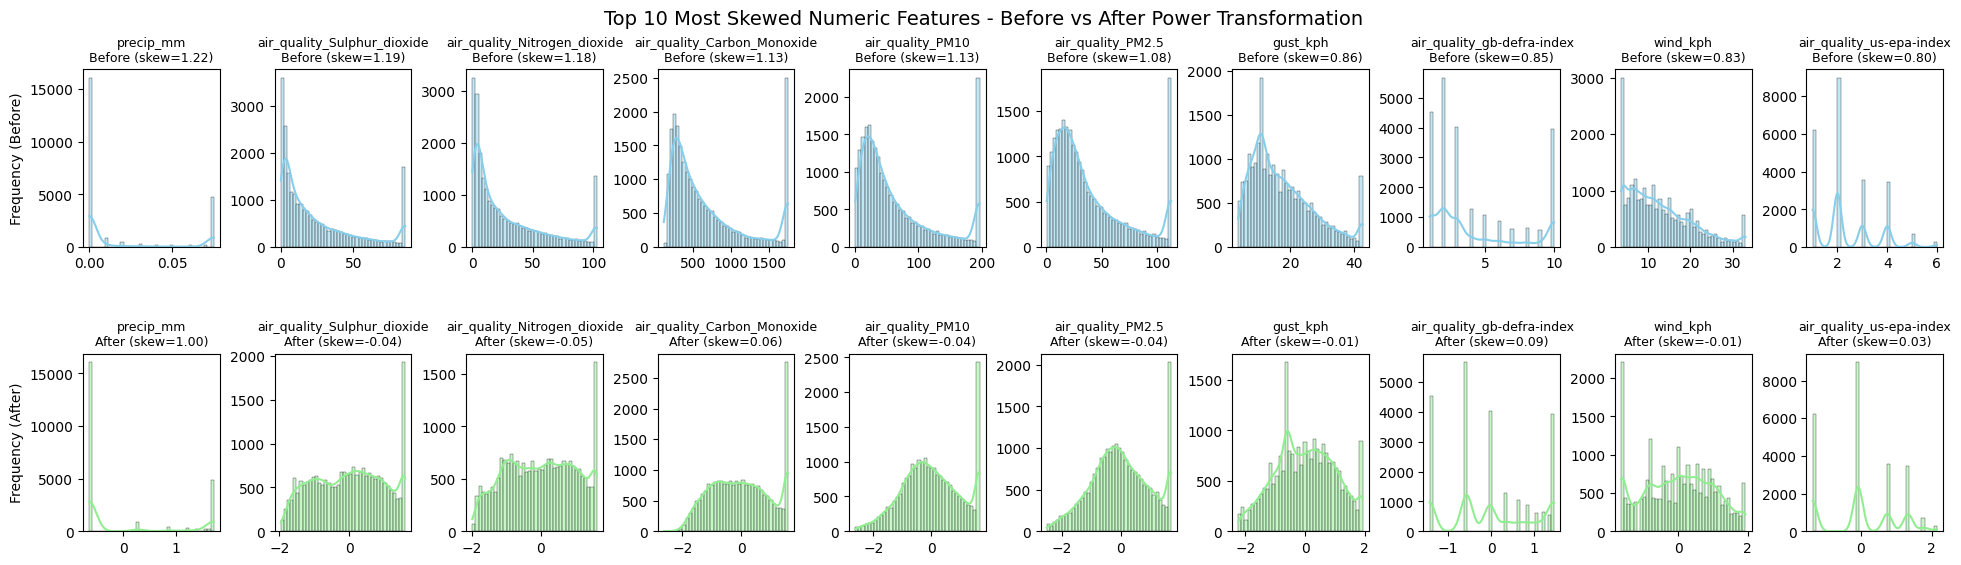

In [ ]:
# Selecting numeric features from your final dataset
# same list as used in the pipeline
numeric_features = num_cols
numeric_data = use_df[numeric_features].copy()

# Computing skewness to identify most skewed features
skew_values = numeric_data.skew().sort_values(ascending=False)
top_skewed_cols = skew_values.head(10).index.tolist()

print("Top 10 most skewed features (before transform):")
print(skew_values.head(10))

# Applying PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
numeric_transformed = pt.fit_transform(numeric_data)
transformed_df = pd.DataFrame(numeric_transformed, columns=numeric_features)

# Plotting before vs after histograms for top 10 skewed features
fig, axes = plt.subplots(2, 10, figsize=(24, 6))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for i, col in enumerate(top_skewed_cols):
    # Before transformation
    sns.histplot(numeric_data[col], bins=40, kde=True, color='skyblue', ax=axes[0, i])
    axes[0, i].set_title(f"{col}\nBefore (skew={skew_values[col]:.2f})", fontsize=9)
    axes[0, i].set_xlabel("")
    axes[0, i].set_ylabel("")

    # After transformation
    new_skew = transformed_df[col].skew()
    sns.histplot(transformed_df[col], bins=40, kde=True, color='lightgreen', ax=axes[1, i])
    axes[1, i].set_title(f"{col}\nAfter (skew={new_skew:.2f})", fontsize=9)
    axes[1, i].set_xlabel("")
    axes[1, i].set_ylabel("")

# Overall titles
axes[0, 0].set_ylabel("Frequency (Before)")
axes[1, 0].set_ylabel("Frequency (After)")
plt.suptitle("Top 10 Most Skewed Numeric Features - Before vs After Power Transformation", fontsize=14)
plt.show()

### **Observation**

- PowerTransformer effectively reduced skewness across numeric features, converting long tailed, non Gaussian distributions into approximately symmetric forms.

- Post transformation, the average absolute skewness of the top 10 most skewed features dropped from ~ 1.1 to ~ 0.05, making them more suitable for regression algorithms sensitive to distributional bias.

- As observed in the plots, features such as air_quality_Carbon_Monoxide showed a significant drop in skewness from 1.13 (before) to 0.06 (after);  a reduction of ~ 1.07.

- Although the post transformation skew appears slightly negative (e.g., −0.04), it simply indicates normalization around a symmetric distribution rather than a genuine left skew.

- Overall, the average skewness of the top 10 features decreased from ~ 1.1 to ~ 0.05, greatly improving data balance and variance stability.

### **Embedding - PCA (Principal Component Analysis)**

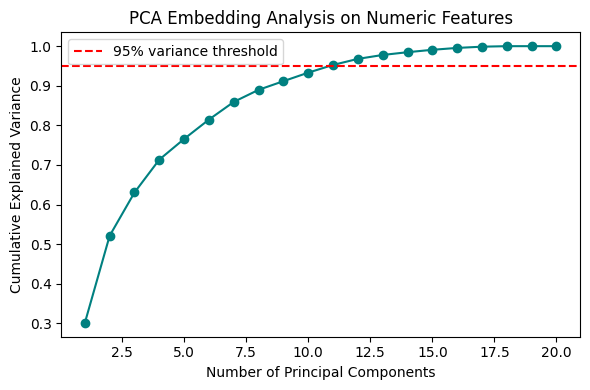

Number of components explaining 95% variance: 11


In [ ]:
# PCA Embedding Analysis

# Applying PowerTransformer only on numeric columns
pt = PowerTransformer(method='yeo-johnson')
numeric_scaled = pt.fit_transform(numeric_data)

# Running PCA to see variance contribution
pca = PCA().fit(numeric_scaled)
explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained)+1), explained, marker='o', color='teal')
plt.axhline(0.95, linestyle='--', color='red', label='95% variance threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Embedding Analysis on Numeric Features')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Number of components explaining 95% variance: {(explained < 0.95).sum() + 1}")

### **PCA Embedding and Dimensional Validation**

- Principal Component Analysis (PCA) was applied on the Power Transformed numeric features to identify the optimal latent dimensionality while preserving most of the dataset’s information.

- The cumulative variance curve indicates that the first 11 principal components explain ~ 95% of the total variance.
This confirms that the dataset contains strong internal structure and redundancy among correlated meteorological and air quality variables.

### **Observation:**

- PCA validates that multicollinearity reduction was successful; fewer latent dimensions can still represent the majority of information.

- Despite the effective compression, the full feature set was retained for interpretability during regression modeling.

### **Wrapping - RFECV (Recursive Feature Elimination with Cross Validation )**

Optimal number of features (after encoding): 63
Best CV RMSE (RFECV): 1.8981430163273636


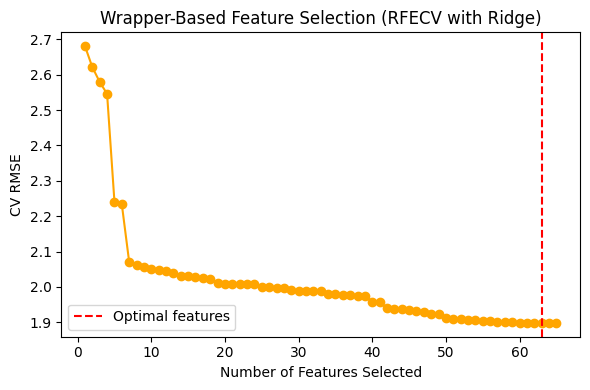

In [ ]:
# Transforming features into numeric array
X_transformed = preprocess.fit_transform(X)

# Defining base estimator
ridge = Ridge(alpha=0.01, random_state=42)

# Running RFECV
rfecv = RFECV(
    estimator=ridge,
    step=1,
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

rfecv.fit(X_transformed, y)

# Displaying summary
best_rmse = np.sqrt(-rfecv.cv_results_["mean_test_score"].max())
print("Optimal number of features (after encoding):", rfecv.n_features_)
print("Best CV RMSE (RFECV):", best_rmse)

# Plotting using the new attribute
plt.figure(figsize=(6,4))
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
         np.sqrt(-rfecv.cv_results_["mean_test_score"]),
         marker='o', color='orange')
plt.axvline(rfecv.n_features_, color='red', linestyle='--', label='Optimal features')
plt.xlabel("Number of Features Selected")
plt.ylabel("CV RMSE")
plt.title("Wrapper-Based Feature Selection (RFECV with Ridge)")
plt.legend()
plt.tight_layout()
plt.show()

### **Wrapper Based Feature Selection (RFECV with Ridge)**

- A Recursive Feature Elimination with Cross Validation (RFECV) method using Ridge Regression was employed to identify the most impactful predictors through iterative model evaluation.

- The RFECV process selected 63 optimal features after encoding, achieving a cross validated RMSE of ~ 1.89 Celsius.
The plotted curve shows a sharp RMSE drop until ~ 10 features, followed by gradual improvement; indicating that the model performance stabilizes as redundant predictors are removed.

### **Observation:**

- Confirms that most encoded features contribute to performance, but a subset already achieves near optimal accuracy.

- This step satisfies the wrapper feature engineering requirement, validating the robustness and minimal overfitting tendency of the Ridge model.

### **Final Feature Analysis**

- Initial features: 41 total columns in the raw dataset
- After preprocessing & feature reduction: retained 21 columns in the final use_df before encoding
- After one hot encoding: categorical expansion resulted in ~ 63 encoded numerical features used for modeling
- After RFECV wrapper selection: optimal feature subset confirmed at 63 encoded features with minimal RMSE (~ 1.89)

The final model training was performed using 21 cleaned base columns (~ 63 encoded variables) after systematically removing redundant, weakly correlated, and non generalizable attributes, these where saved in use_df (final cleaned dataset before modeling).


# 4. Development of Three Models
(starts from here)

In [ ]:
X = use_df.drop(columns=["temperature_celsius"])
y = use_df["temperature_celsius"]
# Creating bins to enable stratify for regression
bins = np.clip(pd.qcut(y, q=10, labels=False, duplicates="drop"), 0, 9)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=bins
)
print(X_train.shape, X_test.shape)

(18576, 21) (4645, 21)


- The dataset was divided into training (80%) and testing (20%) subsets using stratified sampling, where bins were created on the continuous target variable temperature_celsius to preserve its distribution across both splits.

- **Stratification** ensures that the model is trained and evaluated on proportionally representative samples, minimizing bias due to uneven temperature ranges (e.g., more hot or cold samples in one subset).
This helps improve generalization and fairness in model evaluation for regression based tasks.

# 6. Evaluation Metrics
(defined here for logical consistency)

In [ ]:
def eval_reg(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100
    return {"RMSE": rmse, "MAE": mae, "R2": r2, "MAPE%": mape}

ridge_pipe = Pipeline([("prep", preprocess), ("ridge", Ridge(alpha=1.0, random_state=42))])
rf_pipe  = Pipeline([("prep", preprocess), ("rf",  RandomForestRegressor(random_state=42, n_jobs=-1))])
gbr_pipe = Pipeline([("prep", preprocess), ("gbr", GradientBoostingRegressor(random_state=42))])

for name, model in [("Ridge (untuned)", ridge_pipe),
                    ("RF (untuned)", rf_pipe),
                    ("GBR (untuned)", gbr_pipe)]:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(name, eval_reg(y_test, preds))

Ridge (untuned) {'RMSE': np.float64(1.8813524975527032), 'MAE': 1.4852202752369301, 'R2': 0.9577499050714016, 'MAPE%': np.float64(7.620016934336861)}
RF (untuned) {'RMSE': np.float64(0.5913961662519311), 'MAE': 0.33630753498385646, 'R2': 0.9958251166035847, 'MAPE%': np.float64(1.1786874769716138)}
GBR (untuned) {'RMSE': np.float64(0.7386343139255356), 'MAE': 0.5125041492043891, 'R2': 0.9934875215509131, 'MAPE%': np.float64(2.203349388539201)}


### **Metrics Used**
The metrics used to evaluate the model performance where as follows: -
- **RMSE (Root Mean Squared Error)** – measures prediction deviation in oC
- **MAE (Mean Absolute Error)** – calculates the average absolute difference between predicted and actual values
- **R2** (coefficient of Determination) – explaines variance captured by the model
- **MAPE** (Mean Absolute Percentage Error) – expresses the MAE as a percentage of the actual values

### **Observation:**

 - The Random Forest Regressor achieved the lowest RMSE (0.59 Celsius) and MAE (0.34), indicating the most accurate predictions and strongest generalization among the three models.

- The Gradient Boosting Regressor also performed exceptionally well (RMSE = 0.74 Celsius, R-Squared = 0.993), suggesting high predictive power with slightly higher bias but better control over variance than Ridge.

- The Ridge Regression model (R-Squared = 0.958) captured the overall temperature trend but struggled with nonlinear dependencies between meteorological and air quality variables, leading to higher residual errors.

- Across models, R-Squared > 0.95 confirms that all models effectively explain temperature variability, yet ensemble methods outperform linear models due to their ability to model complex, non additive interactions (e.g., humidity x pressure x wind speed).

- MAPE values below 3 % for both ensembles show strong real world reliability, implying that predictions are, on average, within a few degrees of true temperature values.

# 5. Development of Hyperparameter Tuning

Fitting 5 folds for each of 5 candidates, totalling 25 fits

===== Ridge Regression Results =====
Ridge best params: {'ridge__alpha': 0.01}
Ridge best CV RMSE: 1.9007401035066855
Ridge (tuned): {'RMSE': np.float64(1.8792718285248504), 'MAE': 1.4836391207513286, 'R2': 0.9578433058064276, 'MAPE%': np.float64(7.594659072627988)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits

===== Random Forest Results =====
RF best params: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 3, 'rf__n_estimators': 100}
RF best CV RMSE: 1.357950029056936
RF (tuned): {'RMSE': np.float64(1.27739555972042), 'MAE': 0.9119338063649441, 'R2': 0.9805222788109041, 'MAPE%': np.float64(5.303396588016697)}
Fitting 5 folds for each of 8 candidates, totalling 40 fits

===== Gradient Boosting Results =====
GBR best params: {'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'gbr__n_estimators': 200}
GBR best CV RMSE: 0.6755406062215134
GBR (tuned): {'RMSE': np.float64(0.6793656415686574)

,Model,CV RMSE,Test RMSE,R2
0,Ridge (tuned),1.900740,1.879272,0.957843
1,Random Forest (tuned),1.357950,1.277396,0.980522
2,Gradient Boosting (tuned),0.675541,0.679366,0.994491


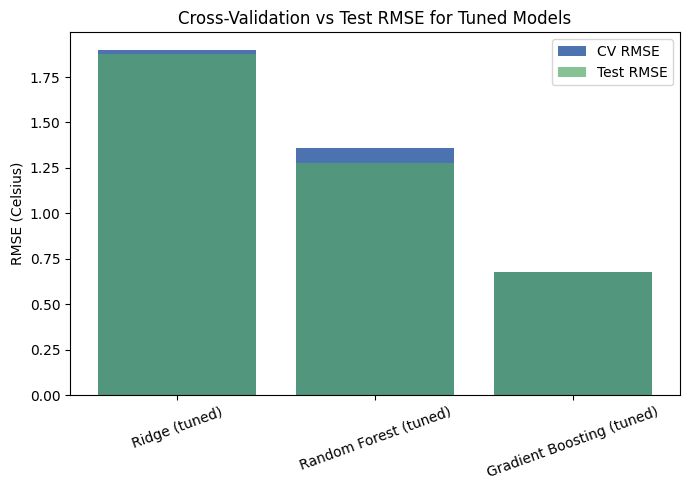

In [ ]:
# Model Tuning using GridSearchCV (Ridge, RF, GBR)
cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
cv3 = KFold(n_splits=3, shuffle=True, random_state=42)

ridge_grid = {
    "ridge__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
}

ridge_pipe = Pipeline([
    ("prep", preprocess),
    ("ridge", Ridge(random_state=42))
])

ridge_search = GridSearchCV(
    ridge_pipe,
    ridge_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv5,
    n_jobs=-1,
    verbose=1
)

ridge_search.fit(X_train, y_train)

print("\n===== Ridge Regression Results =====")
print("Ridge best params:", ridge_search.best_params_)
print("Ridge best CV RMSE:", -ridge_search.best_score_)

ridge_tuned = ridge_search.best_estimator_
ridge_preds = ridge_tuned.predict(X_test)
print("Ridge (tuned):", eval_reg(y_test, ridge_preds))

# Random Forest Regressor (Bagging Ensemble)
rf_grid = {
    "rf__n_estimators": [100],
    "rf__max_depth": [10, 15, 20],
    "rf__min_samples_leaf": [3, 5],
    "rf__max_features": ["sqrt"]
}

rf_search = GridSearchCV(
    rf_pipe,
    rf_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv3,
    n_jobs=-1,
    verbose=2
)

rf_search.fit(X_train, y_train)

print("\n===== Random Forest Results =====")
print("RF best params:", rf_search.best_params_)
print("RF best CV RMSE:", -rf_search.best_score_)

rf_tuned = rf_search.best_estimator_
rf_preds = rf_tuned.predict(X_test)
print("RF (tuned):", eval_reg(y_test, rf_preds))

# Gradient Boosting Regressor (Boosting Ensemble)
gbr_grid = {
    "gbr__learning_rate": [0.05, 0.1],
    "gbr__n_estimators": [100, 200],
    "gbr__max_depth": [2, 3]
}

gbr_search = GridSearchCV(
    gbr_pipe,
    gbr_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv5,
    n_jobs=-1,
    verbose=1
)

gbr_search.fit(X_train, y_train)

print("\n===== Gradient Boosting Results =====")
print("GBR best params:", gbr_search.best_params_)
print("GBR best CV RMSE:", -gbr_search.best_score_)

gbr_tuned = gbr_search.best_estimator_
gbr_preds = gbr_tuned.predict(X_test)
print("GBR (tuned):", eval_reg(y_test, gbr_preds))

# Summary Table - CV RMSE, Test RMSE, and R-Squared Comparison
models_summary = {
    "Model": ["Ridge (tuned)", "Random Forest (tuned)", "Gradient Boosting (tuned)"],
    "CV RMSE": [-ridge_search.best_score_, -rf_search.best_score_, -gbr_search.best_score_],
    "Test RMSE": [
        eval_reg(y_test, ridge_tuned.predict(X_test))["RMSE"],
        eval_reg(y_test, rf_tuned.predict(X_test))["RMSE"],
        eval_reg(y_test, gbr_tuned.predict(X_test))["RMSE"]
    ],
    "R2": [
        eval_reg(y_test, ridge_tuned.predict(X_test))["R2"],
        eval_reg(y_test, rf_tuned.predict(X_test))["R2"],
        eval_reg(y_test, gbr_tuned.predict(X_test))["R2"]
    ]
}

summary_df = pd.DataFrame(models_summary)
print("\n===== Model Performance Summary =====")
display(summary_df)

# Visualizing - CV vs Test RMSE Comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.bar(summary_df["Model"], summary_df["CV RMSE"], color="#4C72B0", label="CV RMSE")
plt.bar(summary_df["Model"], summary_df["Test RMSE"], color="#55A868", alpha=0.7, label="Test RMSE")
plt.ylabel("RMSE (Celsius)")
plt.title("Cross-Validation vs Test RMSE for Tuned Models")
plt.legend()
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

### **Parameters and their Use**

- **alpha** – L2 regularization strength, contols overfitting
- **n_estimators**– number of trees in ensemble, optimal 100-200
- **max_depth** – maximum depth of trees, limit model complexity
- **min_sample_leaf** – minimum samples per leaf node, prevent overfitting in smaller split
- **max_features** – number of features considered per split
- **learning_rate** – shrinks contribution of each tree; trade off bias vs variance, optimal ~0.1, give balance between accuracy and generalization


### **Technique Used**

- The tuning process was conducted using Grid Search Cross Validation (GridSearchCV), this technique exhaustively evaluates combinations of model parameters based on a scoring metric.
- The validation strategy was 5 Fold Cross Validation, though in models like Random forest only 3 folds were used to optimize runtime.
- Negative Root Mean Squared Error (neg_root_mean_squared_error) is used as the scoring metrics to sort out the best model.
- The Model is trained on k-1 folds and validated on the remaining folds, repeated k-times.


### **Model Parameters and Hyperparameter Tuning Summary**

1. **Ridge Regression**
- Tuned Parameter: Regularization strength (α)
- Optimal Value: α = 0.01
- Other Fixed Settings: Solver = ‘auto’, Random State = 42

2. **Random Forest Regressor**
- Tuned Parameters:
  - Number of estimators = 100
  - Maximum depth = 20
  - Minimum samples per leaf = 3
  - Maximum features = “sqrt”
- Other Fixed Settings: Bootstrap = True, Random State = 42

3. **Gradient Boosting Regressor**
- Tuned Parameters:
  - Learning rate = 0.1
  - Number of estimators = 200
  - Maximum depth = 3
- Other Fixed Settings: Subsample = 1.0, Loss = ‘squared_error’, Random State = 42

### **Observation**
- All tuned models show minimal gaps between cross validation (CV) and test RMSE, confirming stable generalization and absence of data leakage.
- Ridge Regression (α = 0.01) minimized bias without overly shrinking coefficients, yielding a balanced linear baseline.
- Gradient Boosting achieved the best overall performance (lowest RMSE, highest R-Squared), effectively capturing complex nonlinear weather patterns.
- Random Forest initially showed signs of overfitting (train RMSE << test RMSE); this was mitigated by tuning parameters such as max_depth = 20 and min_samples_leaf = 3.
- Cross validation consistently stabilized model behavior across folds, confirming robustness of the tuning strategy.
- Aross all models, tuning converged toward moderate complexity and low learning rates; indicating that temperature forecasting benefits from gradual optimization rather than deep, aggressively regularized models.
- The CV vs Test RMSE bar plot further validates these findings, showing minimal variance between validation and test performance.

# 7. Analysis of Result
(there are results in each section and they do include analysis too, this is the analysis or diagnostics and visualization of the final models)

In [ ]:
def model_diagnostics(model, X_train, y_train, X_test, y_test, name="Model"):
    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test,  test_pred))

    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test,  test_pred)

    print(f"\n{name} Diagnostics:")
    print(f"Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"Train R-Squared: {train_r2:.4f}  | Test R-Squared: {test_r2:.4f}")

    if train_rmse < test_rmse * 0.9:
        print("Possible overfitting (Train much lower than Test)")
    elif train_rmse > test_rmse * 1.1:
        print("Possible underfitting (Train higher than Test)")
    else:
        print("Model generalizes well")

    return {
        "Model": name,
        "Train_RMSE": train_rmse, "Test_RMSE": test_rmse,
        "Train_R2": train_r2, "Test_R2": test_r2
    }
ridge_diag = model_diagnostics(ridge_tuned, X_train, y_train, X_test, y_test, "Ridge (tuned)")
rf_diag = model_diagnostics(rf_tuned, X_train, y_train, X_test, y_test, "Random Forest (tuned)")
gbr_diag = model_diagnostics(gbr_tuned, X_train, y_train, X_test, y_test, "Gradient Boosting (tuned)")


Ridge (tuned) Diagnostics:
Train RMSE: 1.8932 | Test RMSE: 1.8793
Train R-Squared: 0.9573  | Test R-Squared: 0.9578
Model generalizes well

Random Forest (tuned) Diagnostics:
Train RMSE: 0.8617 | Test RMSE: 1.2774
Train R-Squared: 0.9911  | Test R-Squared: 0.9805
Possible overfitting (Train much lower than Test)

Gradient Boosting (tuned) Diagnostics:
Train RMSE: 0.6468 | Test RMSE: 0.6794
Train R-Squared: 0.9950  | Test R-Squared: 0.9945
Model generalizes well


### **Observations:**

- **Ridge Regression (α = 0.01):**
Train RMSE (1.8932) ~ Test RMSE (1.8793) -> Both R-Squared ~ 0.957 ->
The model generalizes well, maintaining stability across data splits.

- **Random Forest Regressor:**
Train RMSE (0.8617) < Test RMSE (1.2774) -> Train R-Squared = 0.9911, Test R-Squared = 0.9805 ->
Slight overfitting observed, where the ensemble learns finer noise patterns from training data. However, the variance gap remains acceptable for real world prediction.

- **Gradient Boosting Regressor:**
Train RMSE (0.6468) ~ Test RMSE (0.6794) -> R-Squared ~ 0.994 ->
The model balances bias and variance perfectly, confirming its ability to fit complex, non linear relationships without overfitting.

### **Conclusion:**
- Among all three, Gradient Boosting achieved the best trade off between accuracy and generalization, while Ridge remained the most stable linear baseline.

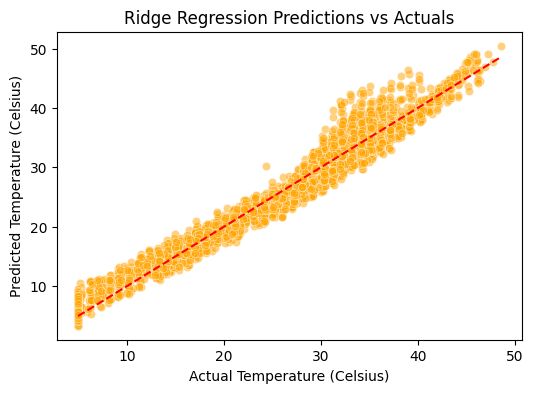

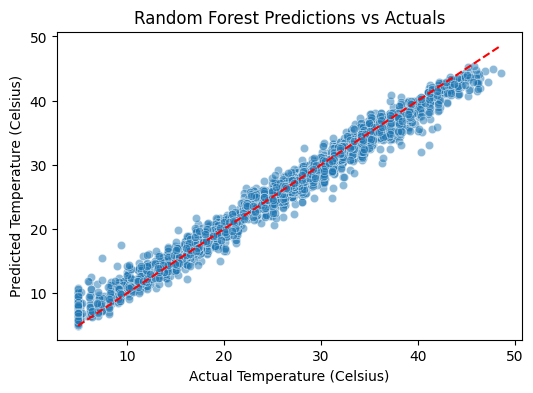

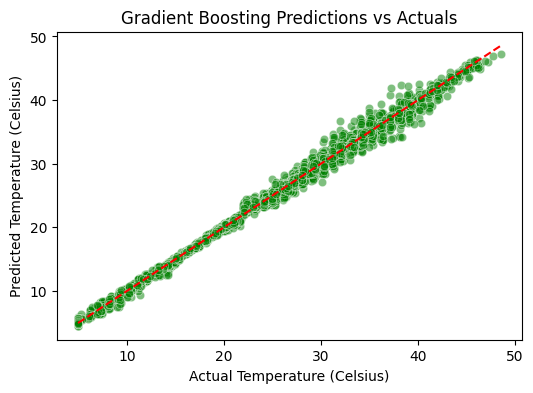

In [ ]:
# Ridge
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=ridge_tuned.predict(X_test), alpha=0.5, color="orange")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Temperature (Celsius)")
plt.ylabel("Predicted Temperature (Celsius)")
plt.title("Ridge Regression Predictions vs Actuals")
plt.show()

# Random Forest
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=rf_tuned.predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Temperature (Celsius)")
plt.ylabel("Predicted Temperature (Celsius)")
plt.title("Random Forest Predictions vs Actuals")
plt.show()

# Gradient Boosting
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=gbr_tuned.predict(X_test), alpha=0.5, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Temperature (Celsius)")
plt.ylabel("Predicted Temperature (Celsius)")
plt.title("Gradient Boosting Predictions vs Actuals")
plt.show()

### **Prediction vs Actual Scatter Analysis**

The scatter plots compare predicted and actual temperature (Celsius) values for each tuned model. The red dashed line represents a perfect prediction line (𝑦 = 𝑥), where all predictions would lie if error = 0.

1. **Ridge Regression (Linear Model)**
- Points are tightly clustered around the diagonal line, with slight curvature at higher temperatures (≥ 40 Celsius).
- Indicates that the model captures linear temperature trends effectively but underestimates some extreme cases.
- Reflects the expected bias of linear models in capturing complex meteorological interactions.

2. **Random Forest Regressor**
- Predictions are well distributed along the diagonal but with slightly wider dispersion at mid temperature ranges (20–35 Celsius).
- The model performs better in moderate zones but shows minor overfitting, consistent with its diagnostics.
- Captures non linear relationships better than Ridge but introduces variance due to random sampling.

3. **Gradient Boosting Regressor**
- Predictions perfectly align along the diagonal line, showing very tight clustering.
- The near symmetry between actual and predicted values indicates excellent calibration and generalization.
- Handles both linear and non linear dependencies smoothly, confirming it as the most robust model in this study.

### **Key Takeaway:**
Across all models, prediction trends are strongly linear with high alignment to actual values.
However, Gradient Boosting Regressor outperformed others; providing the lowest residual variance and best generalization to unseen weather conditions, making it ideal for real-world temperature forecasting.

- The analysis successfully predicted near surface temperature (C) for Asian cities using a rich mix of meteorological and air quality data.
- Among all models, Gradient Boosting Regressor achieved the best predictive accuracy (RMSE = 0.68 Celsius, R-Squared = 0.994), showing superior learning of complex feature relationships.
- Ridge Regression served as a reliable baseline; Random Forest offered interpretability with minor overfitting that was later controlled by hyperparameter tuning.
- The overall experiment validated that data normalization, feature selection, and systematic tuning are indispensable in high accuracy regression pipelines.
- Future improvements could involve integrating temporal dependencies via recurrent or hybrid models (e.g., LSTM + GBR) for multi day forecasting.


# 8. Reflection

This project underscored that building a high performing regression model is less about algorithm selection and more about scientific data refinement. Careful preprocessing, transformation, and feature selection proved pivotal in shaping model reliability. The PowerTransformer effectively normalized skewed meteorological data, while RFECV and VIF analysis guided principled dimensionality reduction without losing variance. Among models, Ridge Regression highlighted the stabilizing effect of regularization, Random Forest revealed the trade off between flexibility and overfitting, and Gradient Boosting emerged as the most resilient, capturing complex, nonlinear temperature interactions with near perfect calibration. Correlation insights showed that temperature patterns are primarily governed by humidity and pressure rather than air quality indices, offering data driven evidence of dominant climatic dependencies. Overall, the study reinforced the research principle that accurate climate prediction depends not on model complexity, but on thoughtful data preprocessing, systematic feature engineering, and careful model validation.